### Preparation

In [57]:
import matplotlib.pyplot as plt
from gym import spaces
from matplotlib.ticker import MultipleLocator

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

import random
import copy
from collections import deque
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

%matplotlib inline

Importing the map of Switzerland.

14061277526569


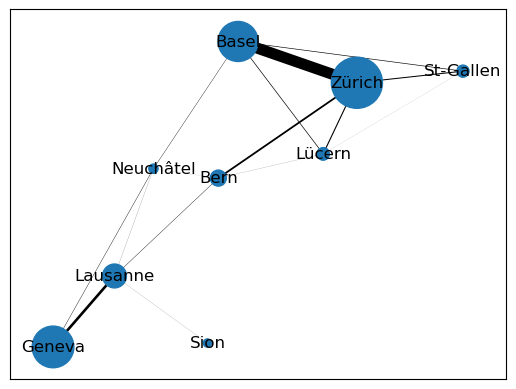

In [2]:
# Map of Switzerland
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map
print(dyn.total_pop**2)
#print(dyn.cities)
dyn.draw_map()

In [1007]:
### FUNCTION FOR PLOTTING RESULTS ###

def plot_results(log):
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    # print(actions)

    """ Plot the results """
    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0,1,2,3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

In [1201]:
### HISTOGRAM PLOTTING FUNCTION ###

def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.vlines([np.median(data)],0,ymax,color='blue')
    ax.hist(data, bins=60 ,range=x_range)
    ax.grid()

In [999]:
### EVALUATION FUNCTION ###

def evaluation(environment, agent, times = 50):
    # initialize the records.
    confine_list = []
    dead_list = []
    reward_list = []
    
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    seeds = torch.randint(0, 100000, (times,))
    for i in range(times):
        epi_confine = 0
        epi_dead = 0
        epi_reward = 0
        obs, info = environment.reset((int(seeds[i])))
        finished = False
        
        while not finished:
            action = agent.act(obs)
            obs, R, finished, info = environment.step(action)
            #print(type(R)): <class 'torch.Tensor'>
            epi_reward += float(R)
            epi_confine += 7 * int(info.action['confinement'])
            if finished:
                break
        epi_dead = info.total.dead

        confine_list.append(epi_confine)
        dead_list.append(epi_dead)
        reward_list.append(epi_reward)

    return confine_list, dead_list, reward_list

In [14]:
### AN OVERVIEW OF THE ENVIRONMENT ###
environment = Env(dyn)
obs, info = environment.reset(0)
print(obs)

Observation(pop={'Lausanne': 295000, 'Geneva': 900000, 'Sion': 34978, 'Neuchâtel': 44531, 'Basel': 830000, 'Bern': 133115, 'Lücern': 82000, 'St-Gallen': 76213, 'Zürich': 1354000}, city={'Lausanne': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Geneva': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Sion': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Neuchâtel': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Basel': Observables(infected=[0, 0, 0, 0, 2, 1, 2], dead=[0, 0, 0, 0, 0, 0, 0]), 'Bern': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'Lücern': Observables(infected=[0, 0, 0, 0, 0, 0, 0], dead=[0, 0, 0, 0, 0, 0, 0]), 'St-Gallen': Observables(infected=[45, 58, 175, 140, 269, 217, 484], dead=[0, 0, 0, 0, 0, 1, 3]), 'Zürich': Observables(infected=[0, 0, 0, 0, 2, 4, 5], dead=[0, 0, 0, 0, 0, 0, 0])}, total=Observables(infected=[45, 58, 175, 140, 273, 

### Question 1: Simulation with Null Action

In [929]:
### INITIALIZE THE ENVIRONMENT ###

environment = Env(dyn)

In [930]:
### EPIDEMIC SIMULATION UNDER NULL ACTION###

null_action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

seed = 1
log1 = []
finished = False
obs, info = environment.reset(seed)
print(info)
while not finished:
    action = null_action
    obs, R, finished, info = environment.step(action)
    log1.append(info) # save the information dict for logging
    if finished:
        break

Log(total=Parameters(day=0, suceptible=3627060, exposed=92441, infected=15075, recovered=15236, dead=178, initial_population=3749837), city={'Lausanne': Parameters(day=0, suceptible=294832, exposed=139, infected=11, recovered=16, dead=0, initial_population=295000), 'Geneva': Parameters(day=0, suceptible=777400, exposed=92300, infected=15064, recovered=15220, dead=178, initial_population=900000), 'Sion': Parameters(day=0, suceptible=34977, exposed=0, infected=0, recovered=0, dead=0, initial_population=34978), 'Neuchâtel': Parameters(day=0, suceptible=44528, exposed=2, infected=0, recovered=0, dead=0, initial_population=44531), 'Basel': Parameters(day=0, suceptible=829999, exposed=0, infected=0, recovered=0, dead=0, initial_population=830000), 'Bern': Parameters(day=0, suceptible=133114, exposed=0, infected=0, recovered=0, dead=0, initial_population=133115), 'Lücern': Parameters(day=0, suceptible=81999, exposed=0, infected=0, recovered=0, dead=0, initial_population=82000), 'St-Gallen': P

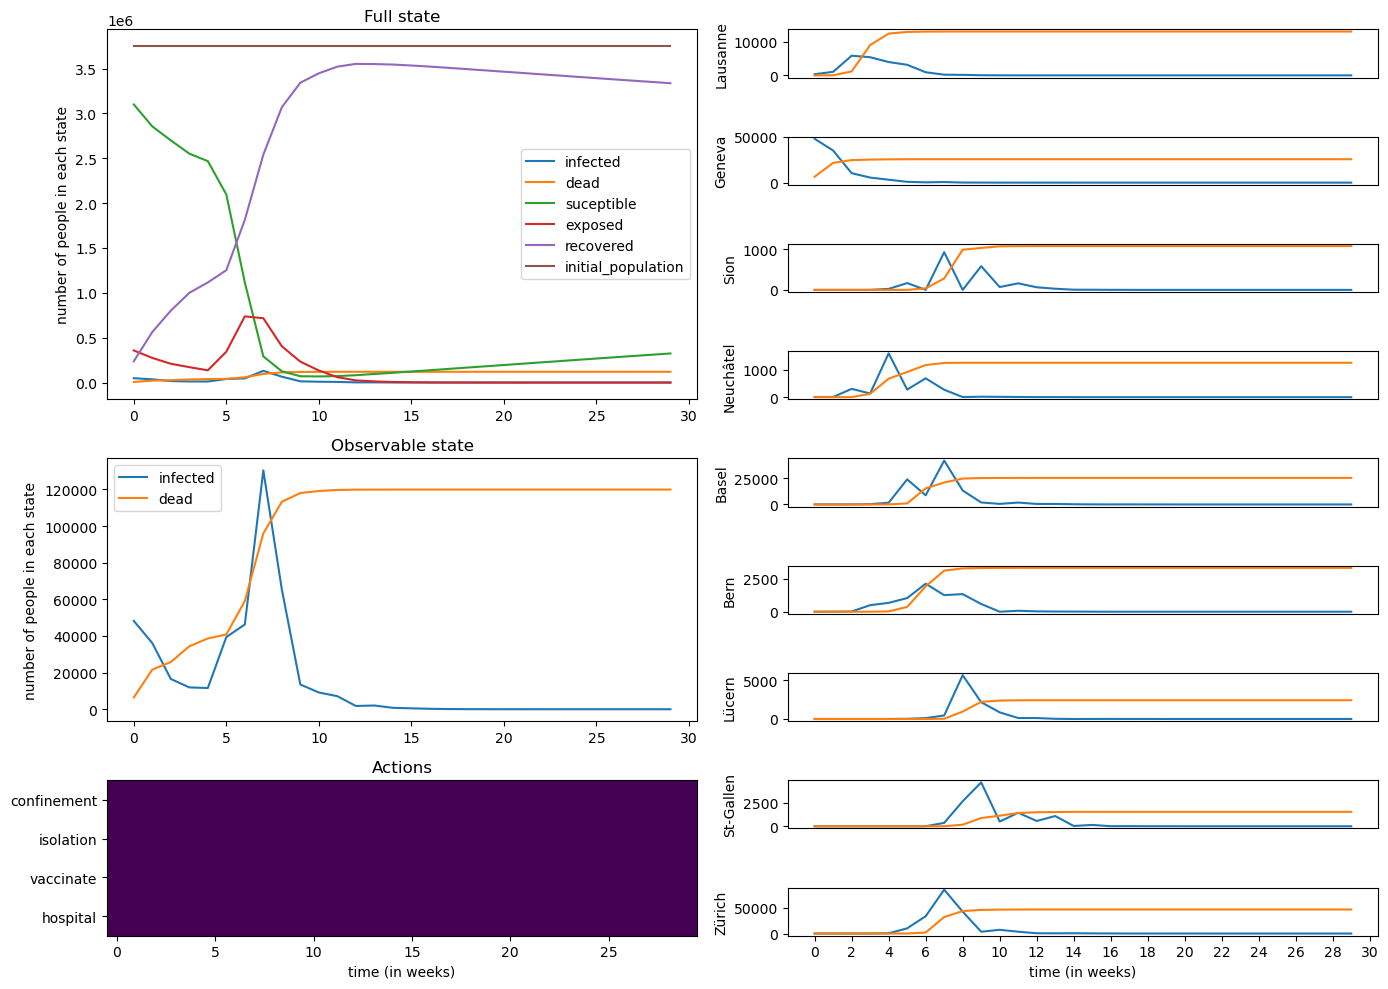

In [932]:
### Plot the results ###
plot_results(log1)

### Question 2: Simulation with Prof Russo's Policy

Question 2.a) Implementation of Prof Russo's Policy

In [586]:
### RUSSO'S POLICY: CONFINEMENT FOR 4 WEEKS WHEN INFECTED > 20000 ###

class Russo(Agent):
    def __init__(self,  env:Env):
        self.env = env
        self.confine_weeks_left = 0

    def initialize(self, seed=None):
        '''Initialize the agent'''
        self.confine_weeks_left = 0
        pass
        
    def load_model(self, path):
        pass

    def save_model(self, path):
        pass

    def optimize_model(self):
        return 0
    
    def reset(self):
        pass
    
    def act(self, obs):
        if self.confine_weeks_left == 0:
           if obs.total.infected[-1] > 20000: 
               self.confine_weeks_left = 3
               action =  {'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}
           else:
               action =  {'confinement': False, 'isolation': False, 'hospital': False, 'vaccinate': False}
               
        else:
            self.confine_weeks_left -= 1
            action =  {'confinement': True, 'isolation': False, 'hospital': False, 'vaccinate': False}

        return action

In [587]:
### EPIDEMIC SIMULATION UNDER RUSSO'S POLICY ###

environment = Env(dyn)
agent = Russo(environment)

seed = 1

log2 = []
finished = False
obs, info = environment.reset(seed)
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = environment.step(action)
    log2.append(info) # save the information dict for logging
    if finished:
        break


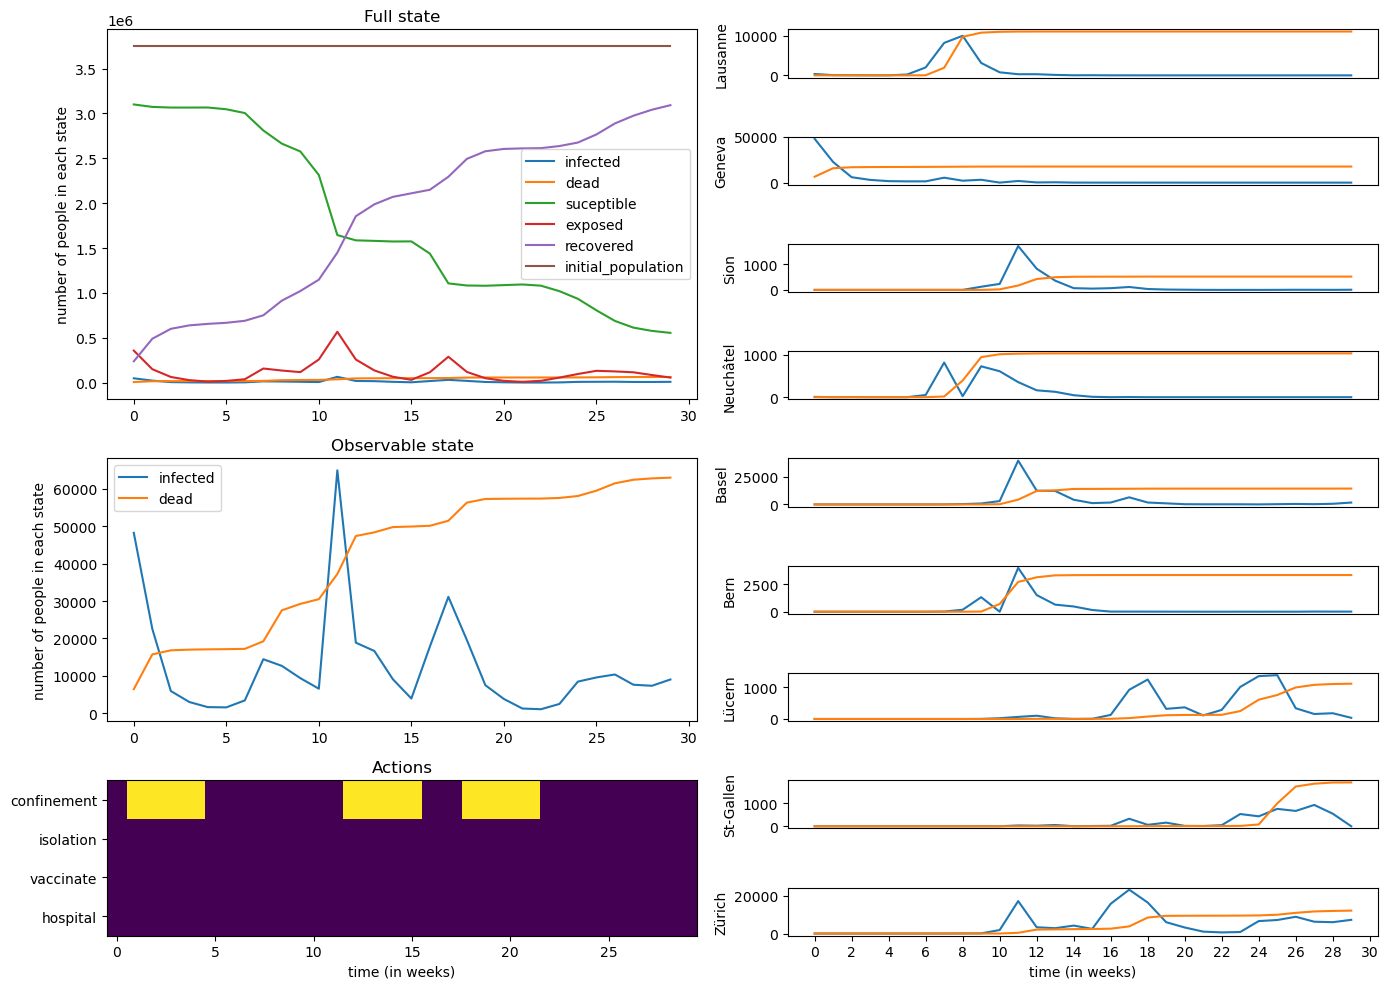

In [588]:
### PLOT THE RESULTS ###
plot_results(log2)

Qustion 2.b) Evaluate Russo's Policy

In [1064]:
### VARIABLE TYPE CHECKING FOR "environment.step()" ###
environment = Env(dyn)
agent = Russo(environment)
obs, info = environment.reset(1)
action = agent.act(obs)
obs, R, finished, info = environment.step(action)
print("type of obs:", type(obs)) #
print("type of R:", type(R))
print("type of finished:", type(finished))
print("type of info:", type(info))
"""
type of obs: <class 'epidemic_env.dynamics.Observation'>
type of R: <class 'torch.Tensor'>
type of finished: <class 'bool'>
type of info: <class 'epidemic_env.env.Log'>
"""


type of obs: <class 'epidemic_env.dynamics.Observation'>
type of R: <class 'torch.Tensor'>
type of finished: <class 'bool'>
type of info: <class 'epidemic_env.env.Log'>


"\ntype of obs: <class 'epidemic_env.dynamics.Observation'>\ntype of R: <class 'torch.Tensor'>\ntype of finished: <class 'bool'>\ntype of info: <class 'epidemic_env.env.Log'>\n"

In [1140]:
# EVALUATION ON RUSSO'S POLICY ###
seed = 1
environment = Env(dyn)
agent = Russo(environment)
confine_list, dead_list, reward_list = evaluation(environment, agent, times = 50)

In [1141]:
### HISTOGRAMS ###
fig, ax = plt.subplots(3,1,figsize=(12,8))
hist_avg(ax[0], confine_list, 'days of confinement')
hist_avg(ax[1], dead_list, 'deaths')
hist_avg(ax[2], reward_list, 'cumulative rewards')
fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))

mean reward:  -70.01046199411154
median reward:  -71.87793917953968
mean death:  59739.58
median death:  60942.5
mean confinement:  99.12
median confinement:  112.0


In [1235]:
### Evaluation Curve for 50/500 (for Question 5a)###
env = Env(dyn)
agent = Russo(env)

n_process = 3
russo_total_training_trace = []
russo_total_evaluation_trace = []
np.random.seed(42)
seeds_process = np.random.randint(0, 100, n_process) # control the seeds for each process

for i in range(n_process):
    print("process: ", i)
    training_trace = []
    evaluation_trace = []

    for j in range(500):
        agent.initialize()
        obs, _ = env.reset()
        finished = False
        while not finished:
            action = agent.act(obs)
            obs, R, finished, _ = env.step(action)
            if finished:
                break
        training_trace.append(int(R))
    russo_total_training_trace.append(training_trace)
        
# for each 20-episode evaluation, the mean reward would be the same
eval_reward = []
for t in range(20):
    agent.initialize()
    obs, _ = env.reset(seed = int(2 * t))
    finished = False
    while not finished:
        action = agent.act(obs)
        obs, R, finished, _ = env.step(action)
        eval_reward.append(int(R))
        if finished:
            break
evaluation_trace = [np.mean(eval_reward)] * 10
print("mean reward: ", np.mean(eval_reward))
russo_total_evaluation_trace = [evaluation_trace] * 3

process:  0
process:  1
process:  2
mean reward:  -3.1566666666666667


In [1236]:
### PLOTTING THE TRACES ###
x1 = np.arange(1, len(russo_total_training_trace[0]) + 1)
y1 = np.array(russo_total_training_trace[0])

x2 = np.arange(1, len(russo_total_training_trace[1]) + 1)
y2 = np.array(russo_total_training_trace[1])

x3 = np.arange(1, len(russo_total_training_trace[2]) + 1)
y3 = np.array(russo_total_training_trace[2])

# Scatter plot
plt.scatter(x1, y1, s=10, c='orange', label='training trace 1')
plt.scatter(x2, y2, s=10, c='lightgreen', label='training trace 2')
plt.scatter(x3, y3, s=10, c='lightblue', label='training trace 3')

# line plot
x_line = np.linspace(1, 501, 10)
y_line = np.array(evaluation_trace[:10])
highest_idx = np.argmax(y_line)
lowest_idx = np.argmin(y_line)
plt.plot(x_line, y_line, c='red', label='average evaluation trace')

plt.scatter(x_line[highest_idx], y_line[highest_idx], s=100, facecolors='none', edgecolors='red', linewidths=2,
            label='highest evaluation reward')

plt.text(x_line[highest_idx], y_line[highest_idx], f'Highest: {y_line[highest_idx]:.2f}',
         horizontalalignment='left', verticalalignment='bottom', color='red')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')


plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Trace & Evaluation Trace of DQN')
plt.legend(fontsize=6, loc='lower right')

plt.show()



### Question 3: A DQN approach

Question 3.a): Implementation of the Deep Q-Learning

In [1368]:
### DEFINING THE ADAPTIVE ACTION & OBESERVATION PREPROCESSORS ###

action_space        =   spaces.MultiBinary(1)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = np.power(SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 0.25)
    dead = np.power(SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 0.25)
    # confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [1014]:
### ESTABLISHING THE DNN CLASS ###

class DNN(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        hidden_size1 = 64
        hidden_size2 = 32
        hidden_size3 = 16
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # separate the batch_size and flattened_size
        # e.g. (2048, 3, 9, 7) -> (2048, 189)
        batch_size = x.size(0)
        flattened_size = torch.prod(torch.tensor(x.size()[1:]))
        x = x.view(batch_size, flattened_size)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        output = self.fc4(x)
        return output
    
    def reset_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.zeros_(module.bias)

In [1047]:
### DQN AGENT ###

class DQN_Agent(Agent):
    """
    Define the class for the DQN agent;
    """
    def __init__(self, env, input_size, output_size, gamma: float = 0.9, epsilon: float = 0.7, lr: float = 5e-3, batch_size: int = 2048, buffer_capacity: int = 20000):
        self.env = env
        self.epsilon = epsilon 
        self.lr = lr
        self.gamma = gamma # discount factor
        self.input_size = input_size
        self.output_size = output_size

        self.batch_size = batch_size 
        self.buffer_capacity = buffer_capacity 
        self.stored_transition = deque(maxlen=self.buffer_capacity)
        self.network = DNN(input_size, output_size)
        self.target_network = copy.deepcopy(self.network) 

        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr)
        #self.loss = nn.SmoothL1Loss() # Huber loss
        self.loss = nn.MSELoss() # MSE loss

    def save_model(self, path):
        torch.save(self.network.state_dict(), path)

    def load_model(self, path):
        self.network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.network.state_dict())

    def act(self, obs):
        """
        Return the action for the given observation;
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.output_size)
        else:
            return int(self.network(obs).argmax(dim = 1)[0])
            # argmax().[0] extracts the value from the tensor
        
    def store_transition(self, transition):
        """
        Store the transition into the replay buffer;
        transition is a tuple containing (state, action, next_state, reward, done)
        """
        self.stored_transition.append(transition)

    def experience_replay(self):
        """
        Experience Replay
        """
        batch = random.sample(self.stored_transition, self.batch_size)
        return batch
    
    def optimize_model(self):
        """
        Optimize the network;
        """
        if len(self.stored_transition) < self.batch_size:
            # i.e. the buffer is not full yet
            return 0

        else:
            batch = self.experience_replay()
            state, action, next_state, reward, done = zip(*batch) 
            states = torch.cat([torch.tensor(s).clone().detach() for s in state])
            next_states = torch.cat([torch.tensor(ns).clone().detach() for ns in next_state])
            actions = torch.cat([torch.tensor(a).reshape(1).clone().detach().long().unsqueeze(1) for a in action])
            # reshape(1): actions from torch.Size([]) to torch.Size([n_batch])
            # long(): adapt for gather()
            # unsqueeze(1): actions has shape torch.Size([n_batch,]) for gather()
            rewards = torch.cat([torch.tensor(r).reshape(1).clone().detach() for r in reward])
            dones = torch.cat([torch.tensor(int(d)).reshape(1).clone().detach() for d in done])
            
            q_values = self.network(states).gather(1, actions) 
            # self.network(states) has shape torch.Size([n_batch, output_size])
            # q_values has shape torch.Size([n_batch, 1])
            
            with torch.no_grad():
                next_q_values = self.target_network(next_states).max(dim = 1)[0]
            
            labelled_q_values = rewards + self.gamma * next_q_values * (1. - dones)
            loss = self.loss(q_values.flatten(), labelled_q_values.flatten())
            
            self.optimizer.zero_grad() # prevent accumulative gradients
            loss.backward()
            self.optimizer.step()

            return loss.item()
        
    def update_target_network(self):
        """
        Update the target network;
        """
        self.target_network = copy.deepcopy(self.network)

    def reset(self):
        self.stored_transition.clear()
        self.network.reset_weights()
        self.target_network = copy.deepcopy(self.network)
  


In [1016]:
### LEARNING PROCEDURE FOR A SINGLE EPISODE ###

def single_episode_learning(env, agent, epsilon, seed = 1):
    """
    Run a single learning episode;
    """
    obs, _ = env.reset(seed) 
    done = False
    epi_reward = 0
    epi_loss = 0
    agent.epsilon = epsilon
    while not done:
        action = agent.act(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.store_transition((obs, action, next_obs, reward, done))
        epi_reward += reward.item()
        obs = next_obs # next state
        loss = agent.optimize_model()
        epi_loss += loss
    return epi_reward, epi_loss

In [1017]:
### SINGLE EVALUATION PROCEDURE ###

def single_episode_evaluation(env, agent, epsilon = 0, seed_evaluation = None, factorized = False):
    """
    Evaluation episodes do not learn !!! --> no storation; no optimization
    """
    obs, _ = env.reset(seed_evaluation)
    done = False
    epi_reward = 0
    epi_loss = 0
    agent.epsilon = epsilon # greedy policy when evaluating
    while not done:
        action = agent.act(obs)
        next_obs, reward, done, _ = env.step(action)
        if factorized: # for factorized DQN agent in Q4
            temp_q_values = agent.q_calculate(obs, istarget=False).gather(1, torch.tensor(action).reshape(1).long().unsqueeze(1))
            labelled_q_values = reward + agent.gamma * agent.q_calculate(next_obs, istarget=True).max(dim = 1)[0]
        else:
            temp_q_values = agent.network(obs).gather(1, torch.tensor(action).reshape(1).long().unsqueeze(1))
            labelled_q_values = reward + agent.gamma * agent.target_network(next_obs).max(dim = 1)[0]
        temp_loss = agent.loss(temp_q_values.flatten(), labelled_q_values.flatten())
        epi_loss += temp_loss.item()
        epi_reward += reward.item()
        obs = next_obs 
    return epi_reward, epi_loss

In [1018]:
### TRAINING FUNCTION: DQN with fixed exploration rate (fixed epsilon) ###

import traceback
def train_log_DQN(env, 
                  agent, 
                  epsilon = 0,
                  num_episodes = 500, 
                  evaluation_interval = 50, 
                  target_update_freq = 5,
                  evaluation_episodes = 20,
                  seed = 1,
                  save_path = None):
    """
    Train the DQN agent;
    """
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    seeds_learning = torch.randint(0, 10000, (num_episodes, ))
    training_trace = []
    evaluation_trace = []
    best_reward_eval = -np.inf # initialized to be extremely small
    agent.reset()

    for i in range(num_episodes):
        try:
            epi_reward, epi_loss = single_episode_learning(env, agent, epsilon, int(seeds_learning[i]))
            training_trace.append(epi_reward)
            print("Episode {}: Epi_Reward: {}, Epi_Loss: {}".format(i + 1, epi_reward, epi_loss))

            if (i + 1) % target_update_freq == 0:
                agent.update_target_network()
                print("Target Network Updated at episode {}.".format(i + 1))

            #evaluation
            if (i + 1) % evaluation_interval == 0:
                print("Evaluation for episode {} starts.".format(i + 1))

                epi_reward_eval_trace = []
                epi_loss_eval_trace = []
                for t in range(evaluation_episodes):
                    epi_reward_eval_temp, epi_loss_eval_temp = single_episode_evaluation(env, agent, epsilon = 0, seed_evaluation = int(2 * t))
                    epi_reward_eval_trace.append(epi_reward_eval_temp) 
                    epi_loss_eval_trace.append(epi_loss_eval_temp)
                epi_reward_eval = np.mean(epi_reward_eval_trace)
                epi_loss_eval = np.mean(epi_loss_eval_trace)
                evaluation_trace.append(epi_reward_eval)
                print("Evaluation at episode {}: Eval_reward = {}; Eval_loss = {}".format(i + 1, epi_reward_eval, epi_loss_eval))

                if epi_reward_eval > best_reward_eval:
                    best_reward_eval = epi_reward_eval
                    if save_path is not None:
                        agent.save_model(save_path)
                        print("Model saved at episode {}.".format(i + 1))
            
                
        except RuntimeError as e:
            print("RuntimeError occurred:")
            traceback.print_exc()
            raise e
    return training_trace, evaluation_trace
        
   

In [1193]:
### INITIALIZE THE ENVIRONMENT AND THE AGENT TYPE ###

env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 2
print(input_size) #126 = 2 * 9 * 7
agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 5e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )


126


In [1020]:
### TRAIN THE AGENT FOR 3 TIMES WITH 500 EPISODES EACH ###

n_process = 3
total_training_trace = []
total_evaluation_trace = []
np.random.seed(42)
seeds_process = np.random.randint(0, 100, n_process) # control the seeds for each process

for process in range(n_process):
    print("======Process {}/{} starts======".format(process + 1, n_process))
    training_trace, evaluation_trace = train_log_DQN(env,
                                                    agent,
                                                    epsilon = 0.7,
                                                    num_episodes = 500,
                                                    evaluation_interval = 50,
                                                    target_update_freq = 5,
                                                    evaluation_episodes = 20,
                                                    seed = seeds_process[process],
                                                    save_path = 'dqn_process_{}.pth'.format(process))


    total_training_trace.append(training_trace)
    total_evaluation_trace.append(evaluation_trace)
    average_evaluation_trace = np.mean(np.array(total_evaluation_trace), axis = 0).tolist()

print("======Training Finished======")

    
    


======Process 1/3 starts======
Episode 1: Epi_Reward: -168.17445611022413, Epi_Loss: 0
Episode 2: Epi_Reward: -88.00267374515533, Epi_Loss: 0
Episode 3: Epi_Reward: -185.23572427034378, Epi_Loss: 0
Episode 4: Epi_Reward: -164.29267971776426, Epi_Loss: 0
Episode 5: Epi_Reward: -155.24612575769424, Epi_Loss: 0
Target Network Updated at episode 5.
Episode 6: Epi_Reward: -56.74266803264618, Epi_Loss: 0
Episode 7: Epi_Reward: -245.67141130007803, Epi_Loss: 0
Episode 8: Epi_Reward: -40.00381326675415, Epi_Loss: 0
Episode 9: Epi_Reward: -121.23346620798111, Epi_Loss: 0
Episode 10: Epi_Reward: -168.90276968479156, Epi_Loss: 0
Target Network Updated at episode 10.
Episode 11: Epi_Reward: -186.78616774082184, Epi_Loss: 0
Episode 12: Epi_Reward: -117.35409971978515, Epi_Loss: 0
Episode 13: Epi_Reward: -60.74790133535862, Epi_Loss: 0
Episode 14: Epi_Reward: -185.55332785844803, Epi_Loss: 0
Episode 15: Epi_Reward: -179.49813866615295, Epi_Loss: 0
Target Network Updated at episode 15.
Episode 16: Ep

/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1985833570.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.cat([torch.tensor(s).clone().detach() for s in state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1985833570.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = torch.cat([torch.tensor(ns).clone().detach() for ns in next_state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1985833570.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewar

Episode 69: Epi_Reward: -187.2112416923046, Epi_Loss: 3835.397636413574
Episode 70: Epi_Reward: -59.70892038196325, Epi_Loss: 2262.449966430664
Target Network Updated at episode 70.
Episode 71: Epi_Reward: -72.54230025410652, Epi_Loss: 2898.4812927246094
Episode 72: Epi_Reward: -127.70389099419117, Epi_Loss: 2025.8910484313965
Episode 73: Epi_Reward: 18.030140325427055, Epi_Loss: 1659.9942054748535
Episode 74: Epi_Reward: -183.4351042509079, Epi_Loss: 1404.4041862487793
Episode 75: Epi_Reward: 6.305932676419616, Epi_Loss: 1137.2300987243652
Target Network Updated at episode 75.
Episode 76: Epi_Reward: -133.59883165359497, Epi_Loss: 1368.9319458007812
Episode 77: Epi_Reward: -239.2553839981556, Epi_Loss: 1367.7776641845703
Episode 78: Epi_Reward: -320.27116429805756, Epi_Loss: 1244.2475547790527
Episode 79: Epi_Reward: -14.082420691847801, Epi_Loss: 1114.78125
Episode 80: Epi_Reward: -5.860758580267429, Epi_Loss: 961.4285755157471
Target Network Updated at episode 80.
Episode 81: Epi_Re

In [1021]:
### SAVE THE TRACES ###
total_training_trace_SAVE = copy.deepcopy(total_training_trace)
total_evaluation_trace_SAVE = copy.deepcopy(total_evaluation_trace)
average_evaluation_trace_SAVE = copy.deepcopy(average_evaluation_trace)

In [1022]:
### PLOTTING THE TRACES ###
x1 = np.arange(1, len(total_training_trace_SAVE[0]) + 1)
y1 = np.array(total_training_trace_SAVE[0])

x2 = np.arange(1, len(total_training_trace_SAVE[1]) + 1)
y2 = np.array(total_training_trace_SAVE[1])

x3 = np.arange(1, len(total_training_trace_SAVE[2]) + 1)
y3 = np.array(total_training_trace_SAVE[2])

# Scatter plot
plt.scatter(x1, y1, s=10, c='orange', label='training trace 1')
plt.scatter(x2, y2, s=10, c='lightgreen', label='training trace 2')
plt.scatter(x3, y3, s=10, c='lightblue', label='training trace 3')

# line plot
x_line = np.linspace(1, 501, 10)
y_line = np.array(average_evaluation_trace_SAVE)
highest_idx = np.argmax(y_line)
lowest_idx = np.argmin(y_line)
plt.plot(x_line, y_line, c='red', label='average evaluation trace')

plt.scatter(x_line[highest_idx], y_line[highest_idx], s=100, facecolors='none', edgecolors='red', linewidths=2,
            label='highest evaluation reward')

plt.text(x_line[highest_idx], y_line[highest_idx], f'Highest: {y_line[highest_idx]:.2f}',
         horizontalalignment='left', verticalalignment='bottom', color='red')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')


plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Trace & Evaluation Trace of DQN')
plt.legend(fontsize=6, loc='lower right')

plt.show()



In [1194]:
### SIMULATION WITH OPTIMAL DQN POLICY ###

agent.load_model('dqn_process_2.pth')
agent.epsilon = 0

seed = 1

log3 = []
finished = False
obs, info = env.reset(seed)
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log3.append(info) # save the information dict for logging
    if finished:
        break

plot_results(log3)


Question 3.b) Decreasing Exploration

In [1188]:
### TRAINING FUNCTION: DQN with decreasing exploration rate (decreasing epsilon) ###

import traceback
def train_log_DQN_decreasing_explore(env, 
                                     agent, 
                                     epsilon_min = 0.2,
                                     epsilon_0 = 0.7,
                                     num_episodes = 500, 
                                     evaluation_interval = 50, 
                                     target_update_freq = 5,
                                     evaluation_episodes = 20,
                                     seed = 1,
                                     save_path = None):
    """
    Train the DQN agent;
    """
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    seeds_learning = torch.randint(0, 10000, (num_episodes, ))
    training_trace = []
    evaluation_trace = []
    best_reward_eval = -np.inf # initialized to be extremely small
    agent.reset()

    for i in range(num_episodes):
        try:
            epsilon = max(epsilon_min, epsilon_0 * (num_episodes - i - 1)/num_episodes)
            epi_reward, epi_loss = single_episode_learning(env, agent, epsilon, int(seeds_learning[i]))
            training_trace.append(epi_reward)
            print("Episode {}: Epi_Reward: {}, Epi_Loss: {}".format(i + 1, epi_reward, epi_loss))

            if (i + 1) % target_update_freq == 0:
                agent.update_target_network()
                print("Target Network Updated at episode {}.".format(i + 1))

            #evaluation
            if (i + 1) % evaluation_interval == 0:
                print("Evaluation for episode {} starts.".format(i + 1))

                epi_reward_eval_trace = []
                epi_loss_eval_trace = []
                for t in range(evaluation_episodes):
                    epi_reward_eval_temp, epi_loss_eval_temp = single_episode_evaluation(env, agent, epsilon = 0, seed_evaluation = int(2 * t), factorized=False)
                    epi_reward_eval_trace.append(epi_reward_eval_temp) 
                    epi_loss_eval_trace.append(epi_loss_eval_temp)
                epi_reward_eval = np.mean(epi_reward_eval_trace)
                epi_loss_eval = np.mean(epi_loss_eval_trace)
                evaluation_trace.append(epi_reward_eval)
                print("Evaluation at episode {}: Eval_reward = {}; Eval_loss = {}".format(i + 1, epi_reward_eval, epi_loss_eval))

                if epi_reward_eval > best_reward_eval:
                    best_reward_eval = epi_reward_eval
                    if save_path is not None and i < 500:
                        agent.save_model(save_path)
                        agent.save_model('MA5_1000_DECREASING_dqn_process_{}.pth'.format(process))
                        print("Model saved at episode {}.".format(i + 1))
                    else:
                        agent.save_model('MA5_1000_DECREASING_dqn_process_{}.pth'.format(process))
                        print("Model* saved at episode {}.".format(i + 1))
            
                
        
        except RuntimeError as e:
            print("RuntimeError occurred:")
            traceback.print_exc()
            raise e
    return training_trace, evaluation_trace
        

In [1189]:
### INITIALIZE THE ENVIRONMENT AND THE AGENT TYPE ###
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 2
print(input_size) #126 = 2 * 9 * 7


agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 5e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

126


In [1030]:
### TRAINING DQN FOR 3 TIMES WITH 500 EPISODES EACH ###

n_process = 3
total_training_trace_de = []
total_evaluation_trace_de = []
np.random.seed(42)
seeds_process = np.random.randint(0, 100, n_process) # control the seeds for each process

for process in range(n_process):
    print("======Process {}/{} starts======".format(process + 1, n_process))
    training_trace, evaluation_trace = train_log_DQN_decreasing_explore(env,
                                                                        agent,
                                                                        epsilon_min = 0.2,
                                                                        epsilon_0 = 0.7,
                                                                        num_episodes = 500,
                                                                        evaluation_interval = 50,
                                                                        target_update_freq = 5,
                                                                        evaluation_episodes = 20,
                                                                        seed = seeds_process[process],
                                                                        save_path = 'DECREASING_dqn_process_{}.pth'.format(process))


    total_training_trace_de.append(training_trace)
    total_evaluation_trace_de.append(evaluation_trace)
    average_evaluation_trace_de = np.mean(np.array(total_evaluation_trace_de), axis = 0).tolist()

print("======Training Finished======")

    
    


======Process 1/3 starts======
Episode 1: Epi_Reward: -168.17445611022413, Epi_Loss: 0
Episode 2: Epi_Reward: -88.00267374515533, Epi_Loss: 0
Episode 3: Epi_Reward: -185.23572427034378, Epi_Loss: 0
Episode 4: Epi_Reward: -164.29267971776426, Epi_Loss: 0
Episode 5: Epi_Reward: -155.24612575769424, Epi_Loss: 0
Target Network Updated at episode 5.
Episode 6: Epi_Reward: -56.74266803264618, Epi_Loss: 0
Episode 7: Epi_Reward: -245.67141130007803, Epi_Loss: 0
Episode 8: Epi_Reward: -40.00381326675415, Epi_Loss: 0
Episode 9: Epi_Reward: -121.23346620798111, Epi_Loss: 0
Episode 10: Epi_Reward: -168.90276968479156, Epi_Loss: 0
Target Network Updated at episode 10.
Episode 11: Epi_Reward: -186.78616774082184, Epi_Loss: 0
Episode 12: Epi_Reward: -116.3105857372284, Epi_Loss: 0
Episode 13: Epi_Reward: -46.983575597405434, Epi_Loss: 0
Episode 14: Epi_Reward: -185.55332785844803, Epi_Loss: 0
Episode 15: Epi_Reward: -179.49813866615295, Epi_Loss: 0
Target Network Updated at episode 15.
Episode 16: Ep

/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1985833570.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.cat([torch.tensor(s).clone().detach() for s in state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1985833570.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = torch.cat([torch.tensor(ns).clone().detach() for ns in next_state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1985833570.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewar

Episode 69: Epi_Reward: -107.5472456663847, Epi_Loss: 4165.57438659668
Episode 70: Epi_Reward: -30.390614047646523, Epi_Loss: 2314.2865600585938
Target Network Updated at episode 70.
Episode 71: Epi_Reward: -198.81765785813332, Epi_Loss: 2828.170867919922
Episode 72: Epi_Reward: -130.32211875915527, Epi_Loss: 1908.4221572875977
Episode 73: Epi_Reward: 15.561766371130943, Epi_Loss: 1541.2265739440918
Episode 74: Epi_Reward: -162.5773868560791, Epi_Loss: 1312.2513694763184
Episode 75: Epi_Reward: 40.790366262197495, Epi_Loss: 1021.2035636901855
Target Network Updated at episode 75.
Episode 76: Epi_Reward: -142.64481708407402, Epi_Loss: 1107.259376525879
Episode 77: Epi_Reward: -11.229515105485916, Epi_Loss: 841.8939361572266
Episode 78: Epi_Reward: -284.9210858345032, Epi_Loss: 857.3745632171631
Episode 79: Epi_Reward: -34.06303275935352, Epi_Loss: 744.7853755950928
Episode 80: Epi_Reward: 16.7802492659539, Epi_Loss: 663.3632907867432
Target Network Updated at episode 80.
Episode 81: Epi

In [1031]:
### SAVE THE TRACES ###
total_training_trace_de_SAVE = copy.deepcopy(total_training_trace_de)
total_evaluation_trace_de_SAVE = copy.deepcopy(total_evaluation_trace_de)
average_evaluation_trace_de_SAVE = copy.deepcopy(average_evaluation_trace_de)

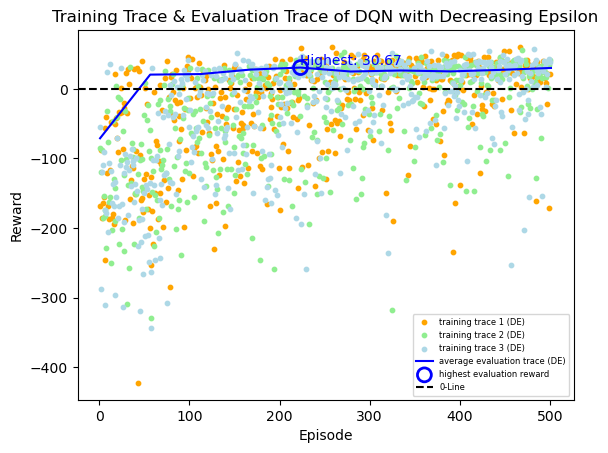

In [1032]:
### PLOT THE TRACES ###
x1 = np.arange(1, len(total_training_trace_de_SAVE[0]) + 1)
y1 = np.array(total_training_trace_de_SAVE[0])

x2 = np.arange(1, len(total_training_trace_de_SAVE[1]) + 1)
y2 = np.array(total_training_trace_de_SAVE[1])

x3 = np.arange(1, len(total_training_trace_de_SAVE[2]) + 1)
y3 = np.array(total_training_trace_de_SAVE[2])

# Scatter plot
plt.scatter(x1, y1, s=10, c='orange', label='training trace 1 (DE)')
plt.scatter(x2, y2, s=10, c='lightgreen', label='training trace 2 (DE)')
plt.scatter(x3, y3, s=10, c='lightblue', label='training trace 3 (DE)')

# line plot
x_line = np.linspace(1, 501, 10)
y_line2 = np.array(average_evaluation_trace_de_SAVE)

highest_idx2 = np.argmax(y_line2)
plt.plot(x_line, y_line2, c='blue', label='average evaluation trace (DE)')

plt.scatter(x_line[highest_idx2], y_line2[highest_idx2], s=100, facecolors='none', edgecolors='blue', linewidths=2,
            label='highest evaluation reward')

plt.text(x_line[highest_idx2], y_line2[highest_idx2], f'Highest: {y_line2[highest_idx2]:.2f}',
         horizontalalignment='left', verticalalignment='bottom', color='blue')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Trace & Evaluation Trace of DQN with Decreasing Epsilon')   
plt.legend(fontsize=6, loc='lower right')
# Display plot
plt.show()



In [1033]:
### COMPARE THE FIXED EXPLORATION AND DECREASING EXPLORATION ###

x1 = np.arange(1, len(total_training_trace_de_SAVE[0]) + 1)
y11 = np.array(total_training_trace_SAVE[0])
y12 = np.array(total_training_trace_de_SAVE[0])


x2 = np.arange(1, len(total_training_trace_de_SAVE[1]) + 1)
y21 = np.array(total_training_trace_SAVE[1])
y22 = np.array(total_training_trace_de_SAVE[1])

x3 = np.arange(1, len(total_training_trace_de_SAVE[2]) + 1)
y31 = np.array(total_training_trace_SAVE[2])
y32 = np.array(total_training_trace_de_SAVE[2])

# Scatter plot

plt.scatter(x1, y11, s=5, c='lightblue', label='training trace (fixed epsilon)')
plt.scatter(x2, y21, s=5, c='lightblue')
plt.scatter(x3, y31, s=5, c='lightblue')

plt.scatter(x1, y12, s=5, c='orange', label='training trace (decreasing epsilon)')
plt.scatter(x2, y22, s=5, c='orange')
plt.scatter(x3, y32, s=5, c='orange')

# line plot
x_line = np.linspace(1, 501, 10)
y_line1 = np.array(average_evaluation_trace_SAVE)
y_line2 = np.array(average_evaluation_trace_de_SAVE)

plt.plot(x_line, y_line1, c='red', label='average evaluation trace')
plt.plot(x_line, y_line2, c='blue', label='average evaluation trace (DE)')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Comparison between Fixed Epsilon and Decreasing Epsilon')   
plt.legend(fontsize=6, loc='lower right')
# Display plot
plt.show()



In [1034]:
### SIMULATION WITH OPTIMAL DQN POLICY ###
agent.load_model('DECREASING_dqn_process_2.pth')
agent.epsilon = 0

seed = 1

log4 = []
finished = False
obs, info = env.reset(seed)
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log4.append(info) # save the information dict for logging
    if finished:
        break

plot_results(log4)


Question 3c

In [1195]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 2

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0, # greedy policy during evaluation
                  lr = 5e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )


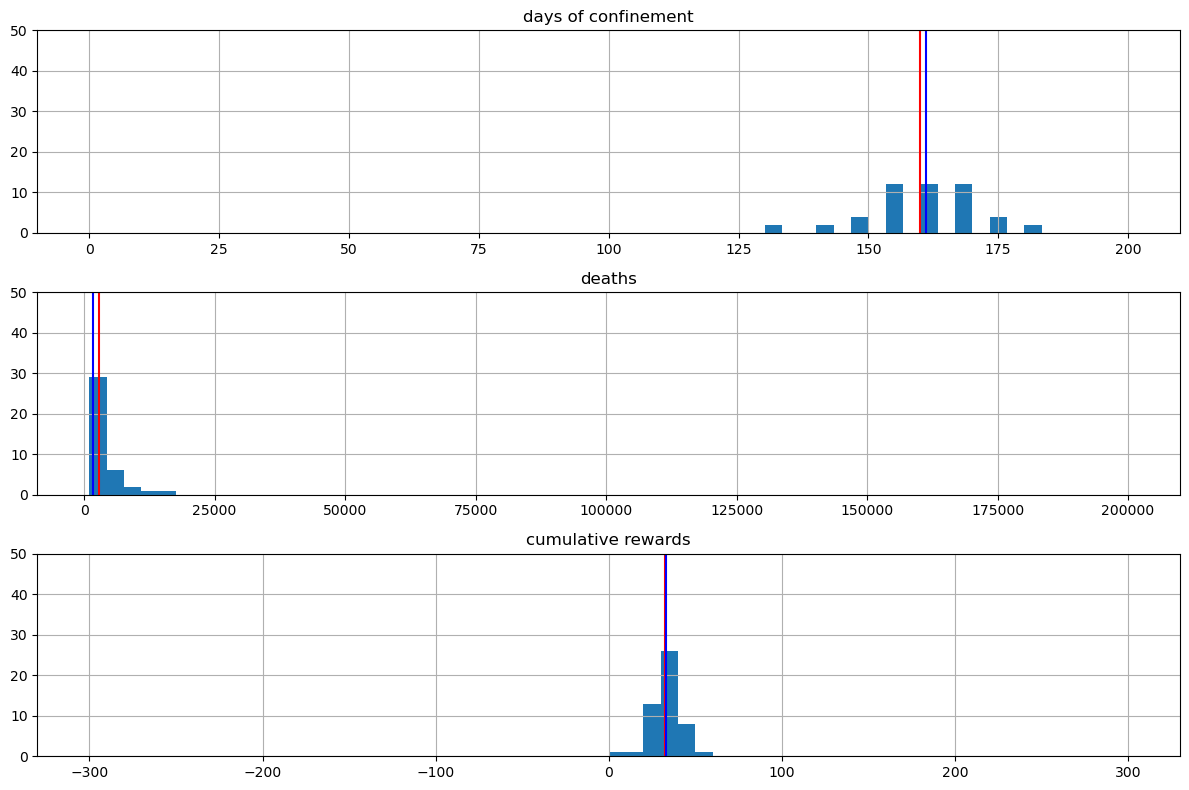

mean reward:  32.77968369461596
median reward:  32.92319977283478
mean death:  2899.4
median death:  1732.0
mean confinement:  159.88
median confinement:  161.0


In [1196]:
### EVALUATION WITH OPTIMAL FIXED-EXPLORATION DQN POLICY ###
agent.load_model(f'dqn_process_2.pth')
confine_list, dead_list, reward_list = evaluation(env, agent, times = 50)
fig, ax = plt.subplots(3,1,figsize=(12,8))
hist_avg(ax[0], confine_list, 'days of confinement')
hist_avg(ax[1], dead_list, 'deaths')
hist_avg(ax[2], reward_list, 'cumulative rewards')
fig.tight_layout()
plt.show()

print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))

In [1202]:
### EVALUATION WITH OPTIMAL DECREASING-EXPLORATION DQN POLICY ###
agent.load_model(f'DECREASING_dqn_process_0.pth')
confine_list, dead_list, reward_list = evaluation(env, agent, times = 50)
fig, ax = plt.subplots(3,1,figsize=(12,8))
hist_avg(ax[0], confine_list, 'days of confinement')
hist_avg(ax[1], dead_list, 'deaths')
hist_avg(ax[2], reward_list, 'cumulative rewards')
fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))


mean reward:  33.93194510743022
median reward:  35.328109949827194
mean death:  3637.96
median death:  1975.0
mean confinement:  155.26
median confinement:  154.0


### Question 4: Multi-Action Policies

Question 4.1 Toggle-action-space multi-action agent

In [1249]:
### INITIALIZING THE ADAPTIVE ACTION & OBSERVATION PREPROCESSORS ###
action_space        =   spaces.MultiBinary(1)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': dyn.get_action()['confinement'], 
        'isolation': dyn.get_action()['isolation'], 
        'hospital': dyn.get_action()['hospital'], 
        'vaccinate': dyn.get_action()['vaccinate']
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = not action['confinement']

    if a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']

    if a == ACTION_HOSPITAL:
        action['hospital'] = not action['hospital']
    
    if a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = np.power(SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 0.25)
    dead = np.power(SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 0.25)
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    isolated = np.ones_like(dead)*int((dyn.get_action()['isolation']))
    hospitalized = np.ones_like(dead)*int((dyn.get_action()['hospital']))
    vaccinated = np.ones_like(dead)*int((dyn.get_action()['vaccinate']))
    return torch.Tensor(np.stack((infected, 
                                  dead, 
                                  confined, 
                                  isolated, 
                                  hospitalized, 
                                  vaccinated))).unsqueeze(0)

In [1250]:
### lr = 1e-3; n_episodes = 500
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 5 # 5 actions
print(input_size) # 378 = (2 + 4) * 9 * 7

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 1e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

# agent.optimizer = optim.Adam(agent.network.parameters(), lr=agent.lr)
# agent.loss = nn.HuberLoss()

378


In [1095]:
### TRAINING WITH lr = 1e-3 for 500 episodes###
n_process = 3
ma3_total_training_trace_de = []
ma3_total_evaluation_trace_de = []
np.random.seed(42)
seeds_process = np.random.randint(0, 100, n_process) # control the seeds for each process

for process in range(n_process):
    print("======Process {}/{} starts======".format(process + 1, n_process))
    training_trace, evaluation_trace = train_log_DQN_decreasing_explore(env,
                                                                        agent,
                                                                        epsilon_min = 0.2,
                                                                        epsilon_0 = 0.7,
                                                                        num_episodes = 500,
                                                                        evaluation_interval = 50,
                                                                        target_update_freq = 5,
                                                                        evaluation_episodes = 20,
                                                                        seed = seeds_process[process],
                                                                        save_path = 'MA3_DECREASING_dqn_process_{}.pth'.format(process))


    ma3_total_training_trace_de.append(training_trace)
    ma3_total_evaluation_trace_de.append(evaluation_trace)
    ma3_average_evaluation_trace_de = np.mean(np.array(ma3_total_evaluation_trace_de), axis = 0).tolist()

print("======Training Finished======")

    
    


======Process 1/3 starts======
Episode 1: Epi_Reward: -179.57241113483906, Epi_Loss: 0
Episode 2: Epi_Reward: -175.32436838001013, Epi_Loss: 0
Episode 3: Epi_Reward: -129.6675032004714, Epi_Loss: 0
Episode 4: Epi_Reward: -143.02358816098422, Epi_Loss: 0
Episode 5: Epi_Reward: -59.68168926984072, Epi_Loss: 0
Target Network Updated at episode 5.
Episode 6: Epi_Reward: 56.121752701699734, Epi_Loss: 0
Episode 7: Epi_Reward: -407.8239362090826, Epi_Loss: 0
Episode 8: Epi_Reward: -288.0305675251875, Epi_Loss: 0
Episode 9: Epi_Reward: -48.6946259601973, Epi_Loss: 0
Episode 10: Epi_Reward: -150.5264361873269, Epi_Loss: 0
Target Network Updated at episode 10.
Episode 11: Epi_Reward: -70.59763713506982, Epi_Loss: 0
Episode 12: Epi_Reward: -41.07563466578722, Epi_Loss: 0
Episode 13: Epi_Reward: -69.00256086885929, Epi_Loss: 0
Episode 14: Epi_Reward: -155.20205365866423, Epi_Loss: 0
Episode 15: Epi_Reward: -369.58645966649055, Epi_Loss: 0
Target Network Updated at episode 15.
Episode 16: Epi_Rewar

/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/3939821680.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.cat([torch.tensor(s).clone().detach() for s in state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/3939821680.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = torch.cat([torch.tensor(ns).clone().detach() for ns in next_state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/3939821680.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewar

Episode 69: Epi_Reward: -103.62832107394934, Epi_Loss: 8453.473693847656
Episode 70: Epi_Reward: -107.42227177578025, Epi_Loss: 9723.004913330078
Target Network Updated at episode 70.
Episode 71: Epi_Reward: -57.13741698488593, Epi_Loss: 7965.844451904297
Episode 72: Epi_Reward: -182.2569083524868, Epi_Loss: 5462.754043579102
Episode 73: Epi_Reward: -57.59877088665962, Epi_Loss: 4323.081642150879
Episode 74: Epi_Reward: -3.5976527109742165, Epi_Loss: 3534.5634231567383
Episode 75: Epi_Reward: -31.814290102105588, Epi_Loss: 2865.6535034179688
Target Network Updated at episode 75.
Episode 76: Epi_Reward: -186.64956895262003, Epi_Loss: 4440.248229980469
Episode 77: Epi_Reward: -43.04864327609539, Epi_Loss: 3097.0185775756836
Episode 78: Epi_Reward: 22.91348145902157, Epi_Loss: 2682.2421340942383
Episode 79: Epi_Reward: -10.375198990106583, Epi_Loss: 2452.4059448242188
Episode 80: Epi_Reward: -20.433562479913235, Epi_Loss: 2185.4914627075195
Target Network Updated at episode 80.
Episode 81

In [1096]:
ma3_total_training_trace_de_SAVE = copy.deepcopy(ma3_total_training_trace_de)
ma3_total_evaluation_trace_de_SAVE = copy.deepcopy(ma3_total_evaluation_trace_de)
ma3_average_evaluation_trace_de_SAVE = copy.deepcopy(ma3_average_evaluation_trace_de)

In [1213]:
print(ma3_average_evaluation_trace_de_SAVE)

[-96.00265723882865, -6.9972955101557694, 6.3980007656500675, 2.2917353801856133, 5.235412521419736, 3.8355550007991646, 5.976138029872285, 11.213665836277263, 14.004976360806419, 14.473778531564555]


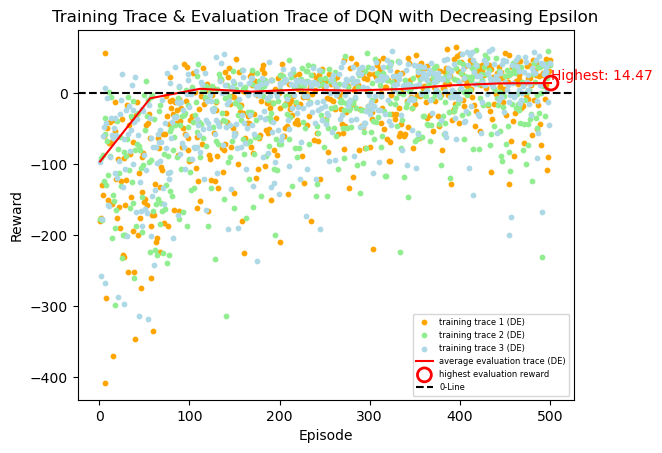

In [1214]:
# 1e-3 (500 episodes)
### PLOT THE TRACES ###
x1 = np.arange(1, len(ma3_total_training_trace_de_SAVE[0]) + 1)
y1 = np.array(ma3_total_training_trace_de_SAVE[0])

x2 = np.arange(1, len(ma3_total_training_trace_de_SAVE[1]) + 1)
y2 = np.array(ma3_total_training_trace_de_SAVE[1])

x3 = np.arange(1, len(ma3_total_training_trace_de_SAVE[2]) + 1)
y3 = np.array(ma3_total_training_trace_de_SAVE[2])

# Scatter plot
plt.scatter(x1, y1, s=10, c='orange', label='training trace 1 (DE)')
plt.scatter(x2, y2, s=10, c='lightgreen', label='training trace 2 (DE)')
plt.scatter(x3, y3, s=10, c='lightblue', label='training trace 3 (DE)')

# line plot
x_line = np.linspace(1, 501, 10)
#y_line1 = np.array(ma3_total_evaluation_trace_de_SAVE[0])
#y_line2 = np.array(ma3_total_evaluation_trace_de_SAVE[1])
#y_line3 = np.array(ma3_total_evaluation_trace_de_SAVE[2])
y_line = np.array(ma3_average_evaluation_trace_de_SAVE)
#highest_idx1 = np.argmax(y_line1)
highest_idx = np.argmax(y_line)
#plt.plot(x_line, y_line1, c='red', label='average evaluation trace')
#plt.plot(x_line, y_line1, c='grey', label='evaluation trace 1 (multiple; DE)')
#plt.plot(x_line, y_line2, c='grey', label='evaluation trace 2 (multiple; DE)')
#plt.plot(x_line, y_line3, c='grey', label='evaluation trace 3 (multiple; DE)')

highest_idx = np.argmax(y_line)
plt.plot(x_line, y_line, c='red', label='average evaluation trace (DE)')

plt.scatter(x_line[highest_idx], y_line[highest_idx], s=100, facecolors='none', edgecolors='red', linewidths=2,
            label='highest evaluation reward')

plt.text(x_line[highest_idx], y_line[highest_idx], f'Highest: {y_line[highest_idx]:.2f}',
         horizontalalignment='left', verticalalignment='bottom', color='red')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Trace & Evaluation Trace of DQN with Decreasing Epsilon')   
plt.legend(fontsize=6, loc='lower right')
# Display plot
plt.show()



In [1115]:
### lr = 1e-5; n_episodes = 1000
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 5 # 5 actions
print(input_size) # 378 = (2 + 4) * 9 * 7

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 1e-5, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

# agent.optimizer = optim.Adam(agent.network.parameters(), lr=agent.lr)
# agent.loss = nn.HuberLoss()

378


In [1116]:
### TRAINING WITH lr = 1e-5 for 1000 episodes###
n_process = 3
ma5_total_training_trace_de = []
ma5_total_evaluation_trace_de = []
np.random.seed(9)
seeds_process = np.random.randint(0, 100, n_process) # control the seeds for each process

for process in range(n_process):
    print("======Process {}/{} starts======".format(process + 1, n_process))
    training_trace, evaluation_trace = train_log_DQN_decreasing_explore(env,
                                                                        agent,
                                                                        epsilon_min = 0.2,
                                                                        epsilon_0 = 0.7,
                                                                        num_episodes = 1000,
                                                                        evaluation_interval = 50,
                                                                        target_update_freq = 5,
                                                                        evaluation_episodes = 20,
                                                                        seed = seeds_process[process],
                                                                        save_path = 'MA5_DECREASING_dqn_process_{}.pth'.format(process))


    ma5_total_training_trace_de.append(training_trace)
    ma5_total_evaluation_trace_de.append(evaluation_trace)
    ma5_average_evaluation_trace_de = np.mean(np.array(ma5_total_evaluation_trace_de), axis = 0).tolist()

print("======Training Finished======")

    
    


======Process 1/3 starts======
Episode 1: Epi_Reward: -194.83912822487764, Epi_Loss: 0
Episode 2: Epi_Reward: -251.33646260458045, Epi_Loss: 0
Episode 3: Epi_Reward: -187.38061629491858, Epi_Loss: 0
Episode 4: Epi_Reward: -124.07967935502529, Epi_Loss: 0
Episode 5: Epi_Reward: -1.3633384853601456, Epi_Loss: 0
Target Network Updated at episode 5.
Episode 6: Epi_Reward: -65.10597397759557, Epi_Loss: 0
Episode 7: Epi_Reward: -80.10698169353418, Epi_Loss: 0
Episode 8: Epi_Reward: -165.44750708341599, Epi_Loss: 0
Episode 9: Epi_Reward: -117.50303939240985, Epi_Loss: 0
Episode 10: Epi_Reward: -126.9618822268676, Epi_Loss: 0
Target Network Updated at episode 10.
Episode 11: Epi_Reward: -46.860755532979965, Epi_Loss: 0
Episode 12: Epi_Reward: -107.46145199984312, Epi_Loss: 0
Episode 13: Epi_Reward: -4.32980860164389, Epi_Loss: 0
Episode 14: Epi_Reward: -83.73885001242161, Epi_Loss: 0
Episode 15: Epi_Reward: -264.5152172744274, Epi_Loss: 0
Target Network Updated at episode 15.
Episode 16: Epi_R

/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/3939821680.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.cat([torch.tensor(s).clone().detach() for s in state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/3939821680.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = torch.cat([torch.tensor(ns).clone().detach() for ns in next_state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/3939821680.py:73: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rewar

Episode 69: Epi_Reward: -138.03601076453924, Epi_Loss: 6731.141174316406
Episode 70: Epi_Reward: -135.80298388004303, Epi_Loss: 8744.747955322266
Target Network Updated at episode 70.
Episode 71: Epi_Reward: -319.73125645518303, Epi_Loss: 8973.516479492188
Episode 72: Epi_Reward: -125.90778854489326, Epi_Loss: 8966.932159423828
Episode 73: Epi_Reward: -226.12028935551643, Epi_Loss: 8975.71401977539
Episode 74: Epi_Reward: -161.91454596817493, Epi_Loss: 9014.082153320312
Episode 75: Epi_Reward: -253.41606134176254, Epi_Loss: 9111.1806640625
Target Network Updated at episode 75.
Episode 76: Epi_Reward: -138.35849444568157, Epi_Loss: 9154.589263916016
Episode 77: Epi_Reward: -229.8800465464592, Epi_Loss: 9587.795196533203
Episode 78: Epi_Reward: -34.165154695510864, Epi_Loss: 9469.088195800781
Episode 79: Epi_Reward: -68.77889624983072, Epi_Loss: 9516.452911376953
Episode 80: Epi_Reward: -273.35392470657825, Epi_Loss: 9735.939392089844
Target Network Updated at episode 80.
Episode 81: Epi

In [1117]:
ma5_total_training_trace_de_SAVE = copy.deepcopy(ma5_total_training_trace_de)
ma5_total_evaluation_trace_de_SAVE = copy.deepcopy(ma5_total_evaluation_trace_de)
ma5_average_evaluation_trace_de_SAVE = copy.deepcopy(ma5_average_evaluation_trace_de)

In [1156]:
# 1e-5 (500/1000 episodes)
x1 = np.arange(1, len(ma5_total_training_trace_de_SAVE[0])/2 + 1)
y1 = np.array(ma5_total_training_trace_de_SAVE[0][:int(len(ma5_total_training_trace_de_SAVE[0])/2)])
print(len(y1))

x2 = np.arange(1, len(ma5_total_training_trace_de_SAVE[1])/2 + 1)
y2 = np.array(ma5_total_training_trace_de_SAVE[1][:int(len(ma5_total_training_trace_de_SAVE[1])/2)])

x3 = np.arange(1, len(ma5_total_training_trace_de_SAVE[2])/2 + 1)
y3 = np.array(ma5_total_training_trace_de_SAVE[2][:int(len(ma5_total_training_trace_de_SAVE[2])/2)])

# Scatter plot
plt.scatter(x1, y1, s=10, c='orange', label='training trace 1 (multiple; DE)')
plt.scatter(x2, y2, s=10, c='lightgreen', label='training trace 2 (multiple; DE)')
plt.scatter(x3, y3, s=10, c='lightblue', label='training trace 3 (multiple; DE)')

# line plot
x_line = np.linspace(1, 501, 10)
#y_line1 = np.array(average_evaluation_trace_SAVE)
y_line1 = np.array(ma5_total_evaluation_trace_de_SAVE[0][:int(len(ma5_total_evaluation_trace_de_SAVE[0])/2)])
print("y_line1: ", len(y_line1))
y_line2 = np.array(ma5_total_evaluation_trace_de_SAVE[1][:int(len(ma5_total_evaluation_trace_de_SAVE[1])/2)])
y_line3 = np.array(ma5_total_evaluation_trace_de_SAVE[2][:int(len(ma5_total_evaluation_trace_de_SAVE[2])/2)])
y_line = np.array(ma5_average_evaluation_trace_de_SAVE[:int(len(ma5_total_evaluation_trace_de_SAVE[2])/2)])
#highest_idx1 = np.argmax(y_line1)
highest_idx = np.argmax(y_line)
#plt.plot(x_line, y_line1, c='red', label='average evaluation trace')
plt.plot(x_line, y_line1, c='grey', label='evaluation trace 1 (multiple; DE)')
plt.plot(x_line, y_line2, c='grey', label='evaluation trace 2 (multiple; DE)')
plt.plot(x_line, y_line3, c='grey', label='evaluation trace 3 (multiple; DE)')
plt.plot(x_line, y_line, c='red', label='average evaluation trace (multiple; DE)')


plt.scatter(x_line[highest_idx], y_line[highest_idx], s=100, facecolors='none', edgecolors='red', linewidths=2,
            label='highest evaluation reward')

#plt.text(x_line[highest_idx1], y_line2[highest_idx1], f'Highest: {y_line[highest_idx1]:.2f}',
#         horizontalalignment='left', verticalalignment='bottom', color='red')

plt.text(x_line[highest_idx], y_line[highest_idx], f'Highest: {y_line[highest_idx]:.2f}',
        ha='left', va='top', color='red')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')
plt.axvline(x=500, color='black', label='500-Episode')

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Trace & Evaluation Trace of DQN with Multiple Actions & Decreasing Epsilon')   
plt.legend(fontsize=6, loc='lower right')
# Display plot
plt.show()



500
y_line1:  10


In [1157]:
### 1e-5 (1000/1000 episodes)
x1 = np.arange(1, len(ma5_total_training_trace_de_SAVE[0]) + 1)
y1 = np.array(ma5_total_training_trace_de_SAVE[0])

x2 = np.arange(1, len(ma5_total_training_trace_de_SAVE[1]) + 1)
y2 = np.array(ma5_total_training_trace_de_SAVE[1])

x3 = np.arange(1, len(ma5_total_training_trace_de_SAVE[2]) + 1)
y3 = np.array(ma5_total_training_trace_de_SAVE[2])

# Scatter plot
plt.scatter(x1, y1, s=10, c='orange', label='training trace 1 (multiple; DE)')
plt.scatter(x2, y2, s=10, c='lightgreen', label='training trace 2 (multiple; DE)')
plt.scatter(x3, y3, s=10, c='lightblue', label='training trace 3 (multiple; DE)')

# line plot
x_line = np.linspace(1, 1001, 20)
#y_line1 = np.array(average_evaluation_trace_SAVE)
y_line1 = np.array(ma5_total_evaluation_trace_de_SAVE[0])
y_line2 = np.array(ma5_total_evaluation_trace_de_SAVE[1])
y_line3 = np.array(ma5_total_evaluation_trace_de_SAVE[2])
y_line = np.array(ma5_average_evaluation_trace_de_SAVE)
#highest_idx1 = np.argmax(y_line1)
highest_idx = np.argmax(y_line)
#plt.plot(x_line, y_line1, c='red', label='average evaluation trace')
plt.plot(x_line, y_line1, c='grey', label='evaluation trace 1 (multiple; DE)')
plt.plot(x_line, y_line2, c='grey', label='evaluation trace 2 (multiple; DE)')
plt.plot(x_line, y_line3, c='grey', label='evaluation trace 3 (multiple; DE)')
plt.plot(x_line, y_line, c='red', label='average evaluation trace (multiple; DE)')


plt.scatter(x_line[highest_idx], y_line[highest_idx], s=100, facecolors='none', edgecolors='red', linewidths=2,
            label='highest evaluation reward')

#plt.text(x_line[highest_idx1], y_line2[highest_idx1], f'Highest: {y_line[highest_idx1]:.2f}',
#         horizontalalignment='left', verticalalignment='bottom', color='red')

plt.text(x_line[highest_idx], y_line[highest_idx], f'Highest: {y_line[highest_idx]:.2f}',
        ha='left', va='top', color='red')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')
plt.axvline(x=500, color='black', label='500-Episode')

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Trace & Evaluation Trace of DQN with Multiple Actions & Decreasing Epsilon')   
plt.legend(fontsize=6, loc='lower right')
# Display plot
plt.show()



In [1215]:
### Evaluation of 1e-3 model ###
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 5 # 5 actions
print(input_size) # 378 = (2 + 4) * 9 * 7

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 1e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )


378


In [1216]:
agent.load_model('MA3_DECREASING_dqn_process_0.pth')
agent.epsilon = 0

seed = 1

log5 = []
finished = False
obs, info = env.reset(seed)
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log5.append(info) # save the information dict for logging
    if finished:
        break

plot_results(log5)


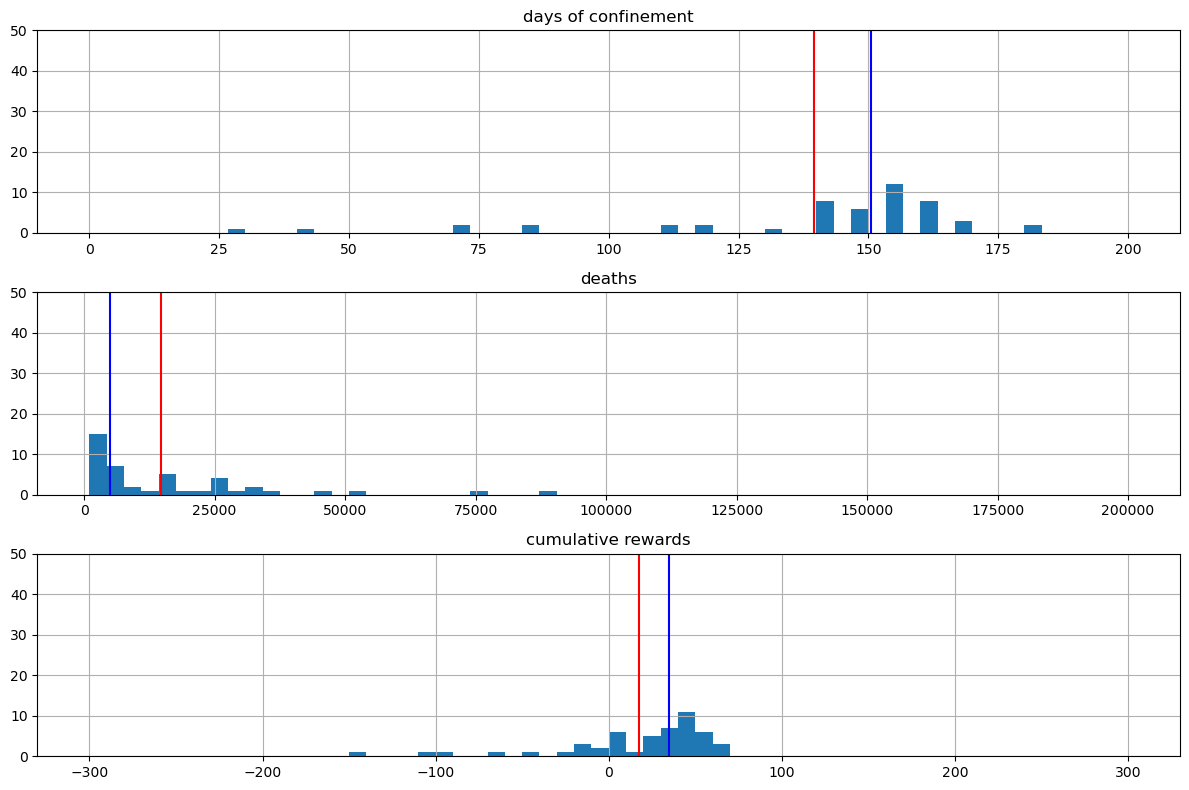

mean reward:  17.763152212102433
median reward:  34.86017306573922
mean death:  14643.0
median death:  4913.5
mean confinement:  139.58
median confinement:  150.5


In [1252]:
agent.load_model(f'MA3_DECREASING_dqn_process_0.pth')
agent.epsilon = 0

confine_list, dead_list, reward_list = evaluation(env, agent, times = 50)

fig, ax = plt.subplots(3,1,figsize=(12,8))
hist_avg(ax[0], confine_list, 'days of confinement')
hist_avg(ax[1], dead_list, 'deaths')
hist_avg(ax[2], reward_list, 'cumulative rewards')
fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))


In [1159]:
### Evaluation of 1e-5 model ###
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 5 # 5 actions
print(input_size) # 378 = (2 + 4) * 9 * 7

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 1e-5, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )


378


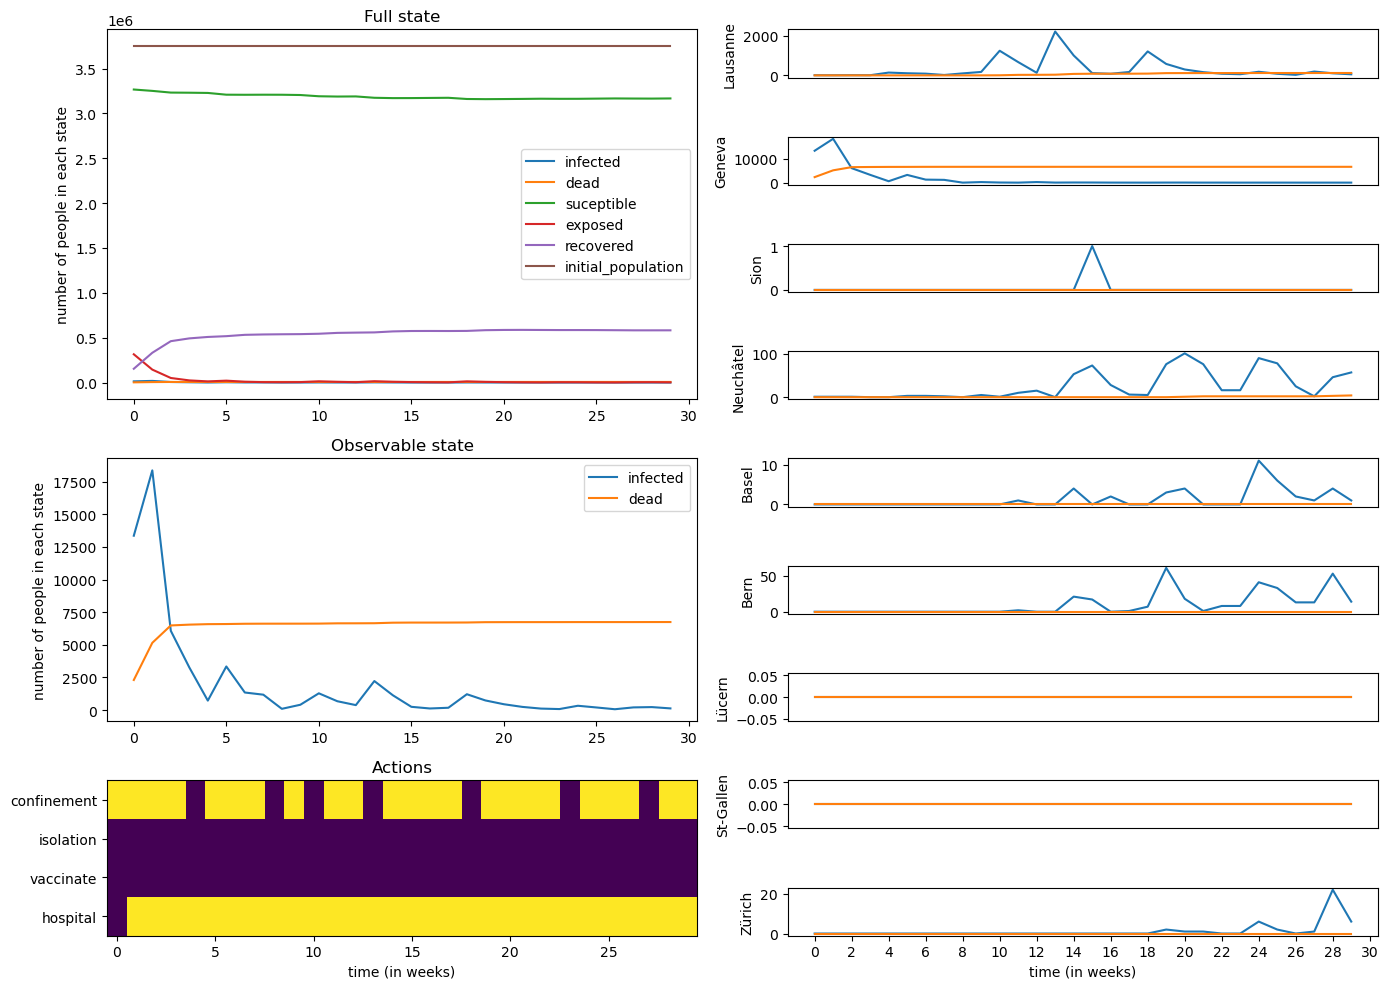

In [1160]:
agent.load_model('MA5_DECREASING_dqn_process_2.pth')
agent.epsilon = 0

seed = 1

log6 = []
finished = False
obs, info = env.reset(seed)
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log6.append(info) # save the information dict for logging
    if finished:
        break

plot_results(log6)


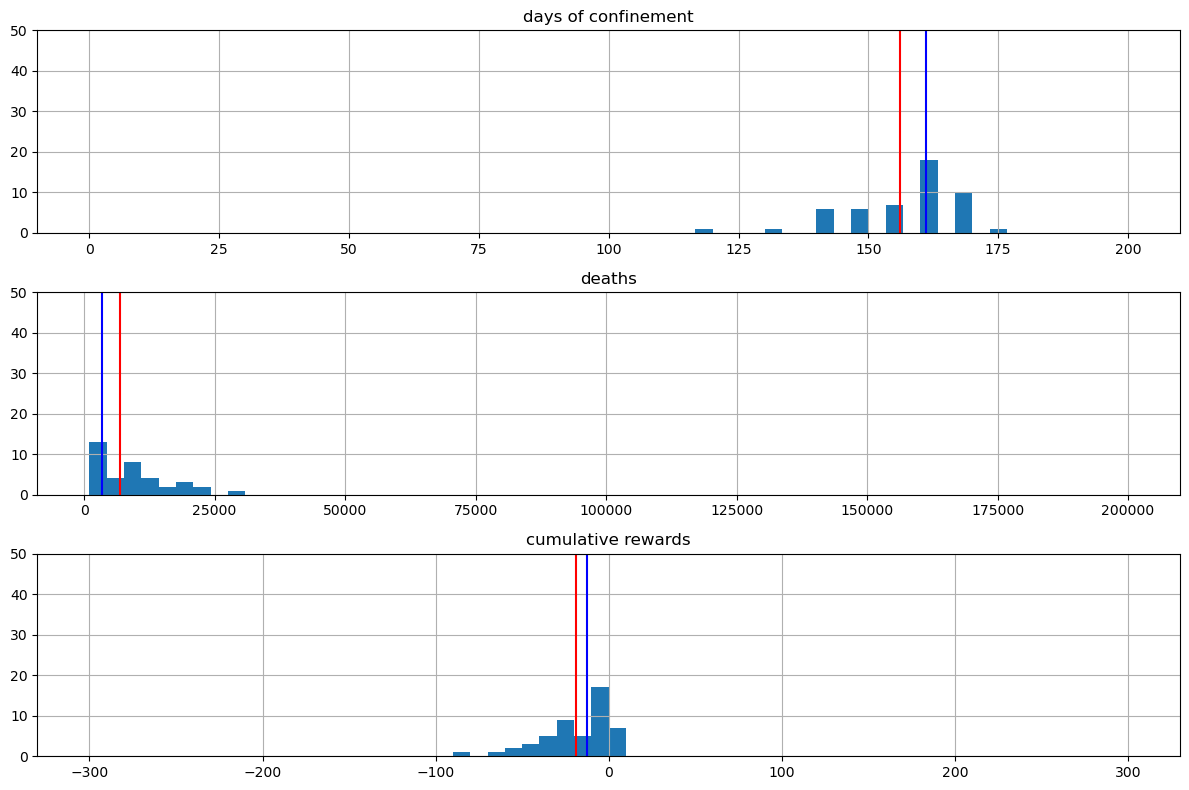

mean reward:  -18.959889443416614
median reward:  -12.271510247490369
mean death:  6886.88
median death:  3393.5
mean confinement:  156.1
median confinement:  161.0


In [1161]:
agent.load_model(f'MA5_DECREASING_dqn_process_2.pth')

confine_list, dead_list, reward_list = evaluation(env, agent, times = 50)

fig, ax = plt.subplots(3,1,figsize=(12,8))
hist_avg(ax[0], confine_list, 'days of confinement')
hist_avg(ax[1], dead_list, 'deaths')
hist_avg(ax[2], reward_list, 'cumulative rewards')
fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))


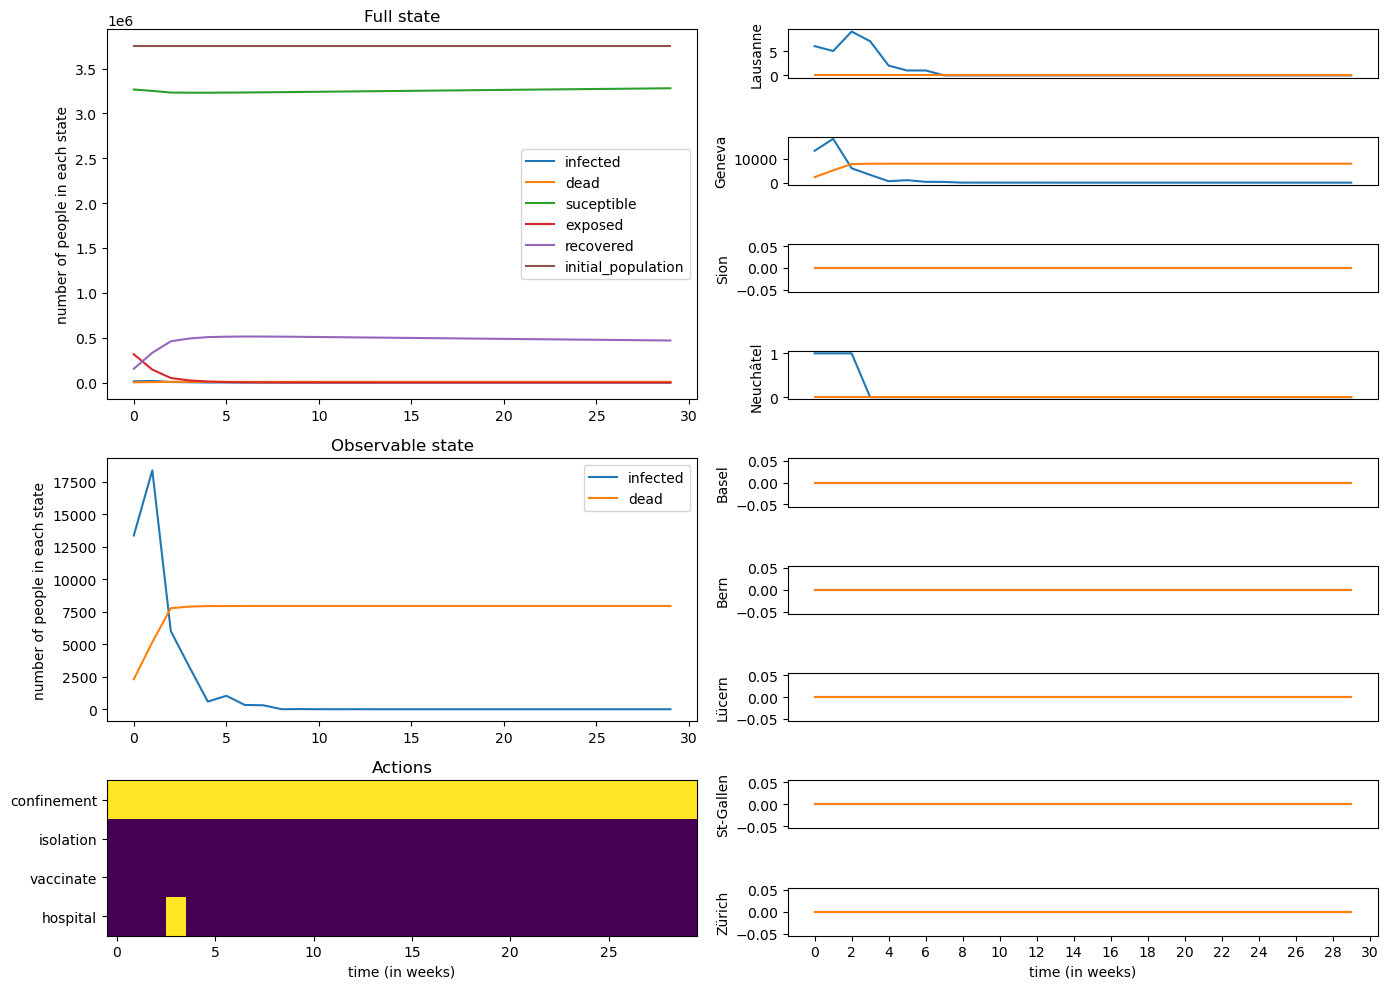

In [1162]:
agent.load_model('MA5_1000_DECREASING_dqn_process_2.pth')
agent.epsilon = 0

seed = 1

log7 = []
finished = False
obs, info = env.reset(seed)
while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log7.append(info) # save the information dict for logging
    if finished:
        break

plot_results(log7)


In [1163]:
agent.load_model(f'MA5_1000_DECREASING_dqn_process_2.pth')

confine_list, dead_list, reward_list = evaluation(env, agent, times = 50)

fig, ax = plt.subplots(3,1,figsize=(12,8))
hist_avg(ax[0], confine_list, 'days of confinement')
hist_avg(ax[1], dead_list, 'deaths')
hist_avg(ax[2], reward_list, 'cumulative rewards')
fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))


mean reward:  12.988137031218503
median reward:  21.708129074424505
mean death:  9736.56
median death:  3958.5
mean confinement:  181.72
median confinement:  210.0


Question 4.2

In [1378]:

action_space        =   spaces.MultiBinary(1)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

SCALE = 100
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False
    }

    a_binary = list(bin(a)[2:].zfill(4))
    
    if int(a_binary[0]) == 1:
        action['confinement'] = True

    if int(a_binary[1]) == 1:
        action['isolation'] = True

    if int(a_binary[2]) == 1:
        action['hospital'] = True
    
    if int(a_binary[3]) == 1:
        action['vaccinate'] = True
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = np.power(SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities]), 0.25)
    dead = np.power(SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities]), 0.25)
    #confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    #isolated = np.ones_like(dead)*int((dyn.get_action()['isolation']))
    #hospitalized = np.ones_like(dead)*int((dyn.get_action()['hospital']))
    #vaccinated = np.ones_like(dead)*int((dyn.get_action()['vaccinate']))
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [1175]:
class Factorized_DQN_Agent(Agent):
    """
    Define the class for the DQN agent;
    """
    def __init__(self, env, input_size, output_size, gamma: float = 0.9, epsilon: float = 0.7, lr: float = 5e-3, batch_size: int = 2048, buffer_capacity: int = 20000):
        """
        Set up the parameters for the DQN agent;
        self.env: the environment;
        self.epsilon: exploration rate for epsilon-greedy;
        self.lr: learning rate;
        self.gamma: discount factor;
        self.batch_size: batch size for experience replay;
        self.buffer_capacity: the capacity of the replay buffer;
        self.stored_transition: the replay buffer;
        self.network: Q values for binary action: confinement and no confinement;
        self.target_network: target network for DQN;
        self.optimizer: Adam optimizer;
        self.loss: MSE loss;
        """
        
        self.env = env
        self.epsilon = epsilon 
        self.lr = lr
        self.gamma = gamma 
        self.input_size = input_size
        self.output_size = output_size

        self.batch_size = batch_size 
        self.buffer_capacity = buffer_capacity 
        self.stored_transition = deque(maxlen=self.buffer_capacity)
        self.network = DNN(input_size, output_size)
        self.target_network = copy.deepcopy(self.network) 

        self.optimizer = optim.Adam(self.network.parameters(), lr=self.lr) # initialize the optimizer parameters
        #self.loss = nn.SmoothL1Loss() # Huber loss
        self.loss = nn.MSELoss() # MSE loss

    def save_model(self, path):
        torch.save(self.network.state_dict(), path)

    def load_model(self, path):
        self.network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.network.state_dict())

    def q_calculate(self, obs, istarget=False):
        if istarget:
            output = self.target_network(obs)
        else:
            output = self.network(obs)
        # print("shape of output: ", output.shape)
        n_action = np.power(2, int(self.output_size/2))
        final_q = []
        for i in range(n_action):
            binary = list(bin(i)[2:].zfill(4))
            q = output[:, int(binary[0]) + 0] + output[:, int(binary[1]) + 2] + output[:, int(binary[2]) + 4] + output[:, int(binary[3]) + 6]
            final_q.append(q)
        q_value = torch.stack(final_q, dim = 1)
        # print("shape of q_value: ", q_value.shape)
        return q_value

    def act(self, obs):
        """
        Return the action for the given observation;
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(np.power(2, self.output_size/2))
        else:
            return int(self.q_calculate(obs).argmax(dim = 1)[0])
            # argmax().[0] returns the index of the maximum value of the tensor
        
    def store_transition(self, transition):
        """
        Store the transition into the replay buffer;
        transition is a tuple containing (state, action, next_state, reward, done)
        """
        self.stored_transition.append(transition)

    def experience_replay(self):
        """
        Experience Replay
        """
        batch = random.sample(self.stored_transition, self.batch_size)
        return batch
    
    def optimize_model(self):
        """
        Optimize the network;
        """
        if len(self.stored_transition) < self.batch_size:
            # the buffer is not full yet
            return 0

        else:
            batch = self.experience_replay()
            state, action, next_state, reward, done = zip(*batch) 
            # transpose the elements of each tuple

            # print(torch.tensor(state[0]).shape): torch.Size([1, 3, 9, 7])
            states = torch.cat([torch.tensor(s).clone().detach() for s in state])
            # print(states.shape): torch.Size([2048, 3, 9, 7])

            next_states = torch.cat([torch.tensor(ns).clone().detach() for ns in next_state])

            # print(type(action[0])): <class 'int'>
            # print(torch.tensor(action[0]).reshape(1).long().shape): torch.Size([1])
            # print(torch.tensor(action[0]).long().shape): torch.Size([])
            # print(torch.tensor(action[0]).unsqueeze(0).long().shape): torch.Size([1])
            # print(type(action[0]))

            actions = torch.cat([torch.tensor(a).reshape(1).clone().detach().long().unsqueeze(1) for a in action])
            # reshape(1): actions has shape torch.Size([2048])
            # long(): adapt for gather()
            # unsqueeze(1): actions has shape torch.Size([2048,]) for gather()

            # print(actions)

            rewards = torch.cat([torch.tensor(r).reshape(1).clone().detach() for r in reward])

            dones = torch.cat([torch.tensor(int(d)).reshape(1).clone().detach() for d in done])
            # elements in the tuple "done" are boolean values; transform them to int values

            q_values = self.q_calculate(states, istarget = False).gather(1, actions) 
            
            # self.network(states) has shape torch.Size([2048, 2])
            # actions has shape torch.Size([2048,])
            # q_values has shape torch.Size([2048, 1])
            
            with torch.no_grad():
                next_q_values = self.q_calculate(next_states, istarget = True).max(dim = 1)[0]
                #print('next_q_values shape: ', next_q_values.shape)
            # max().[0] returns the highest value
            labelled_q_values = rewards + self.gamma * next_q_values * (1. - dones)
            loss = self.loss(q_values.flatten(), labelled_q_values.flatten())

            
            self.optimizer.zero_grad() # prevent accumulative gradients
            loss.backward()
            self.optimizer.step() # update the parameters

            return loss.item()
        
    def update_target_network(self):
        """
        Update the target network;
        """
        self.target_network = copy.deepcopy(self.network)

    def reset(self):
        self.stored_transition.clear()
        self.network.reset_weights()
        self.target_network = copy.deepcopy(self.network)
  


    
    

In [1176]:
import traceback
def train_log_DQN_decreasing_explore_fact(env, 
                                     agent, 
                                     epsilon_min = 0.2,
                                     epsilon_0 = 0.7,
                                     num_episodes = 500, 
                                     evaluation_interval = 50, 
                                     target_update_freq = 5,
                                     evaluation_episodes = 20,
                                     seed = 1,
                                     save_path = None):
    """
    Train the DQN agent;
    """
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    seeds_learning = torch.randint(0, 10000, (num_episodes, ))
    training_trace = []
    evaluation_trace = []
    best_reward_eval = -np.inf # initialized to be extremely small
    agent.reset()

    for i in range(num_episodes):
        try:
            epsilon = max(epsilon_min, epsilon_0 * (num_episodes - i - 1)/num_episodes)
            epi_reward, epi_loss = single_episode_learning(env, agent, epsilon, int(seeds_learning[i]))
            training_trace.append(epi_reward)
            print("Episode {}: Epi_Reward: {}, Epi_Loss: {}".format(i + 1, epi_reward, epi_loss))

            if (i + 1) % target_update_freq == 0:
                agent.update_target_network()
                print("Target Network Updated at episode {}.".format(i + 1))

            #evaluation
            if (i + 1) % evaluation_interval == 0:
                print("Evaluation for episode {} starts.".format(i + 1))

                epi_reward_eval_trace = []
                epi_loss_eval_trace = []
                for t in range(evaluation_episodes):
                    epi_reward_eval_temp, epi_loss_eval_temp = single_episode_evaluation(env, 
                                                                                         agent, epsilon = 0, 
                                                                                         seed_evaluation = int(2 * t),
                                                                                         factorized = True)
                    epi_reward_eval_trace.append(epi_reward_eval_temp) 
                    epi_loss_eval_trace.append(epi_loss_eval_temp)
                epi_reward_eval = np.mean(epi_reward_eval_trace)
                epi_loss_eval = np.mean(epi_loss_eval_trace)
                evaluation_trace.append(epi_reward_eval)
                print("Evaluation at episode {}: Eval_reward = {}; Eval_loss = {}".format(i + 1, epi_reward_eval, epi_loss_eval))

                if epi_reward_eval > best_reward_eval:
                    best_reward_eval = epi_reward_eval
                    if save_path is not None:
                        agent.save_model(save_path)
                        print("Model saved at episode {}.".format(i + 1))
            
                
        
        except RuntimeError as e:
            print("RuntimeError occurred:")
            traceback.print_exc()
            raise e
    return training_trace, evaluation_trace
        

In [1177]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 4 * 2 # 8 actions
print(input_size) # 126 = 2 * 9 * 7

agent = Factorized_DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 1e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

126


In [1178]:
### TRAINING ###
n_process = 3
mafact_total_training_trace_de_3 = []
mafact_total_evaluation_trace_de_3 = []
np.random.seed(42)
seeds_process = np.random.randint(0, 100, n_process) # control the seeds for each process

for process in range(n_process):
    print("======Process {}/{} starts======".format(process + 1, n_process))
    training_trace, evaluation_trace = train_log_DQN_decreasing_explore_fact(env,
                                                                            agent,
                                                                            epsilon_min = 0.2,
                                                                            epsilon_0 = 0.7,
                                                                            num_episodes = 500,
                                                                            evaluation_interval = 50,
                                                                            target_update_freq = 5,
                                                                            evaluation_episodes = 20,
                                                                            seed = seeds_process[process],
                                                                            save_path = 'MAFACT-3_DECREASING_dqn_process_{}.pth'.format(process))


    mafact_total_training_trace_de_3.append(training_trace)
    mafact_total_evaluation_trace_de_3.append(evaluation_trace)
    mafact_average_evaluation_trace_de_3 = np.mean(np.array(mafact_total_evaluation_trace_de_3), axis = 0).tolist()

print("======Training Finished======")

    
    


======Process 1/3 starts======
Episode 1: Epi_Reward: -84.8589356392622, Epi_Loss: 0
Episode 2: Epi_Reward: -82.88958992809057, Epi_Loss: 0
Episode 3: Epi_Reward: -116.93245301395655, Epi_Loss: 0
Episode 4: Epi_Reward: -233.0299581438303, Epi_Loss: 0
Episode 5: Epi_Reward: -119.66861076653004, Epi_Loss: 0
Target Network Updated at episode 5.
Episode 6: Epi_Reward: -37.78363757557236, Epi_Loss: 0
Episode 7: Epi_Reward: -162.72069762903266, Epi_Loss: 0
Episode 8: Epi_Reward: -44.34198446571827, Epi_Loss: 0
Episode 9: Epi_Reward: -185.51627814769745, Epi_Loss: 0
Episode 10: Epi_Reward: -105.12624204903841, Epi_Loss: 0
Target Network Updated at episode 10.
Episode 11: Epi_Reward: -54.790698868688196, Epi_Loss: 0
Episode 12: Epi_Reward: -201.59079564618878, Epi_Loss: 0
Episode 13: Epi_Reward: -71.8338852650486, Epi_Loss: 0
Episode 14: Epi_Reward: -117.76572025939822, Epi_Loss: 0
Episode 15: Epi_Reward: -91.5372049510479, Epi_Loss: 0
Target Network Updated at episode 15.
Episode 16: Epi_Rewa

/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1459298832.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.cat([torch.tensor(s).clone().detach() for s in state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1459298832.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_states = torch.cat([torch.tensor(ns).clone().detach() for ns in next_state])
/var/folders/ty/glwljgt93kv4cddc7b1kk26c0000gn/T/ipykernel_64026/1459298832.py:117: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  rew

Episode 69: Epi_Reward: -109.70695680566132, Epi_Loss: 2453.684860229492
Episode 70: Epi_Reward: -210.94808328151703, Epi_Loss: 2614.1577758789062
Target Network Updated at episode 70.
Episode 71: Epi_Reward: -275.3534110933542, Epi_Loss: 2604.171356201172
Episode 72: Epi_Reward: -147.7067406203132, Epi_Loss: 1973.3675079345703
Episode 73: Epi_Reward: -95.98719090223312, Epi_Loss: 1574.9088096618652
Episode 74: Epi_Reward: -46.32628355920315, Epi_Loss: 1335.5771408081055
Episode 75: Epi_Reward: -175.03398236632347, Epi_Loss: 1239.7250175476074
Target Network Updated at episode 75.
Episode 76: Epi_Reward: -97.15825114911422, Epi_Loss: 1781.9512672424316
Episode 77: Epi_Reward: -87.52238721586764, Epi_Loss: 1446.6990432739258
Episode 78: Epi_Reward: -116.90272949635983, Epi_Loss: 1354.1768836975098
Episode 79: Epi_Reward: -50.84445916302502, Epi_Loss: 1246.1012802124023
Episode 80: Epi_Reward: -169.50193405663595, Epi_Loss: 1226.4599952697754
Target Network Updated at episode 80.
Episode

In [1179]:
mafact_total_training_trace_de_3_SAVE = copy.deepcopy(mafact_total_training_trace_de_3)
mafact_total_evaluation_trace_de_3_SAVE = copy.deepcopy(mafact_total_evaluation_trace_de_3)
mafact_average_evaluation_trace_de_3_SAVE = copy.deepcopy(mafact_average_evaluation_trace_de_3)

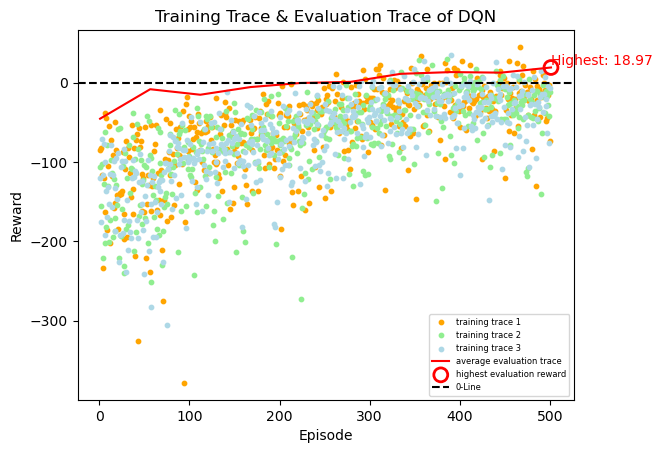

In [1180]:
x1 = np.arange(1, len(mafact_total_training_trace_de_3_SAVE[0]) + 1)
y1 = np.array(mafact_total_training_trace_de_3_SAVE[0])

x2 = np.arange(1, len(mafact_total_training_trace_de_3_SAVE[1]) + 1)
y2 = np.array(mafact_total_training_trace_de_3_SAVE[1])

x3 = np.arange(1, len(mafact_total_training_trace_de_3_SAVE[2]) + 1)
y3 = np.array(mafact_total_training_trace_de_3_SAVE[2])

# Scatter plot
plt.scatter(x1, y1, s=10, c='orange', label='training trace 1')
plt.scatter(x2, y2, s=10, c='lightgreen', label='training trace 2')
plt.scatter(x3, y3, s=10, c='lightblue', label='training trace 3')

# line plot
x_line = np.linspace(1, 501, 10)
y_line = np.array(mafact_average_evaluation_trace_de_3_SAVE)
highest_idx = np.argmax(y_line)
lowest_idx = np.argmin(y_line)
plt.plot(x_line, y_line, c='red', label='average evaluation trace')

plt.scatter(x_line[highest_idx], y_line[highest_idx], s=100, facecolors='none', edgecolors='red', linewidths=2,
            label='highest evaluation reward')

plt.text(x_line[highest_idx], y_line[highest_idx], f'Highest: {y_line[highest_idx]:.2f}',
         horizontalalignment='left', verticalalignment='bottom', color='red')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Trace & Evaluation Trace of DQN')
plt.legend(fontsize=6, loc='lower right')
# Display plot
plt.show()



In [1257]:
### COMPARE THE FIXED EXPLORATION AND DECREASING EXPLORATION ###

x1 = np.arange(1, len(ma3_total_training_trace_de_SAVE[0]) + 1)
y11 = np.array(ma3_total_training_trace_de_SAVE[0])
y12 = np.array(mafact_total_training_trace_de_3_SAVE[0])


x2 = np.arange(1, len(ma3_total_training_trace_de_SAVE[1]) + 1)
y21 = np.array(ma3_total_training_trace_de_SAVE[1])
y22 = np.array(mafact_total_training_trace_de_3_SAVE[1])

x3 = np.arange(1, len(ma3_total_training_trace_de_SAVE[2]) + 1)
y31 = np.array(ma3_total_training_trace_de_SAVE[2])
y32 = np.array(mafact_total_training_trace_de_3_SAVE[2])

# Scatter plot

plt.scatter(x1, y11, s=5, c='lightblue', label='training trace (toggle)')
plt.scatter(x2, y21, s=5, c='lightblue')
plt.scatter(x3, y31, s=5, c='lightblue')

plt.scatter(x1, y12, s=5, c='orange', label='training trace (factorized)')
plt.scatter(x2, y22, s=5, c='orange')
plt.scatter(x3, y32, s=5, c='orange')

# line plot
x_line = np.linspace(1, 501, 10)
y_line1 = np.array(ma3_average_evaluation_trace_de_SAVE)
y_line2 = np.array(mafact_average_evaluation_trace_de_3_SAVE)

plt.plot(x_line, y_line1, c='red', label='average evaluation trace for toggle')
plt.plot(x_line, y_line2, c='blue', label='average evaluation trace for factorized')

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Comparison between toggled and factorized policies')   
plt.legend(fontsize=6, loc='lower right')
# Display plot
plt.show()



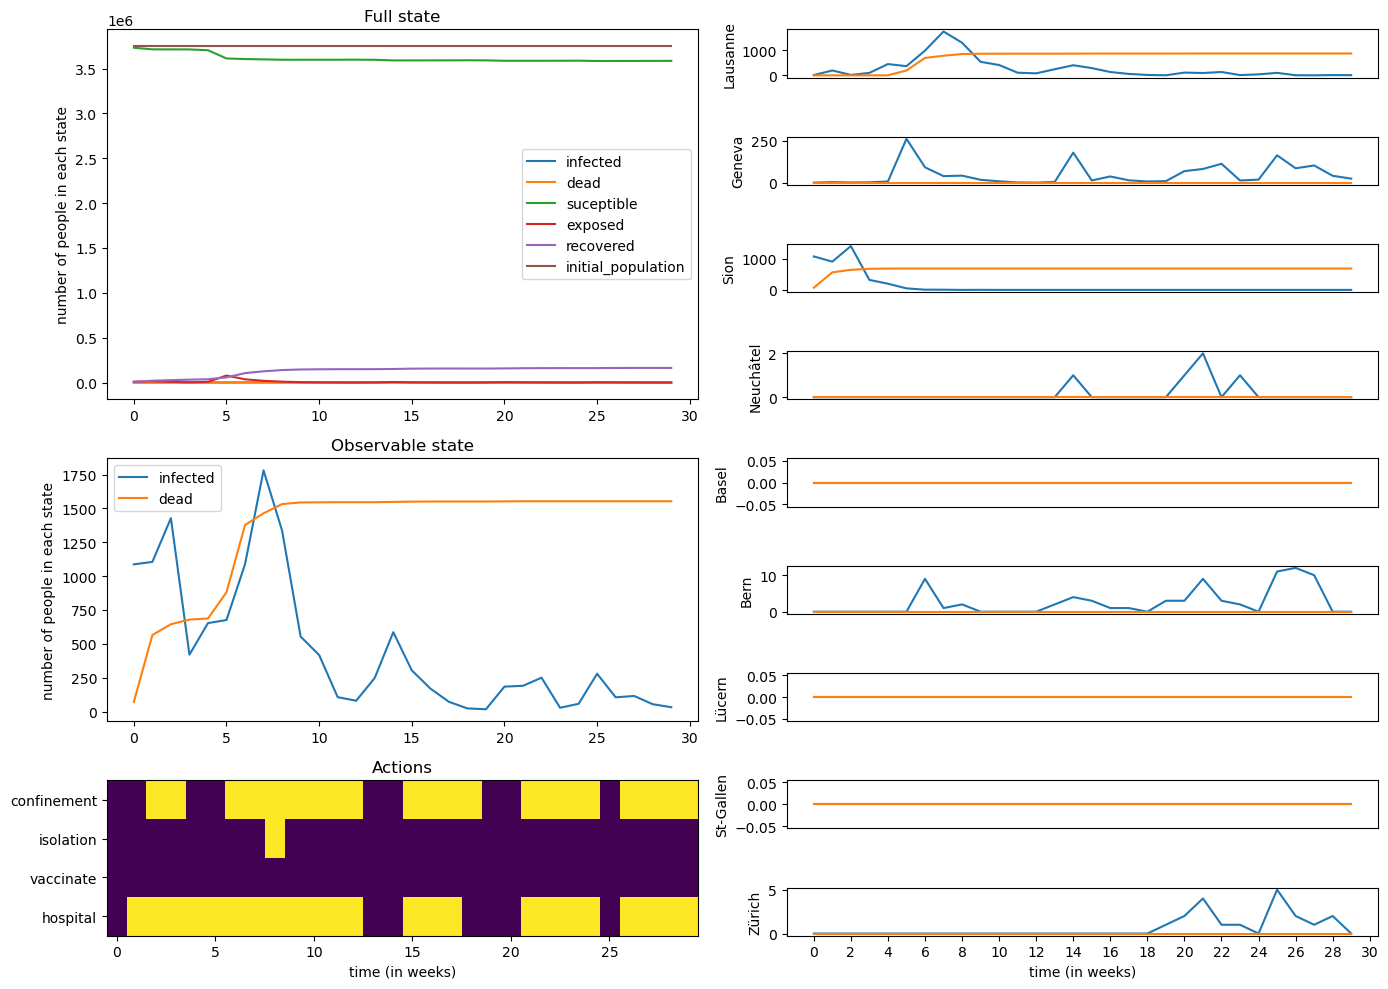

In [1265]:
agent.load_model('MAFACT-3_DECREASING_dqn_process_1.pth')
agent.epsilon = 0

seed = 8

log8 = []
finished = False
obs, info = env.reset(seed)
while not finished:
    action = agent.act(obs)
    #print(action)
    obs, R, finished, info = env.step(action)
    log8.append(info) # save the information dict for logging
    if finished:
        break

plot_results(log8)


In [1186]:
agent.load_model(f'MAFACT-3_DECREASING_dqn_process_0.pth')
agent.epsilon = 0

confine_list, dead_list, reward_list = evaluation(env, agent, times = 50)

fig, ax = plt.subplots(3,1,figsize=(12,8))
hist_avg(ax[0], confine_list, 'days of confinement')
hist_avg(ax[1], dead_list, 'deaths')
hist_avg(ax[2], reward_list, 'cumulative rewards')
fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))


mean reward:  25.69870685205795
median reward:  26.566481885733083
mean death:  3899.7
median death:  2366.5
mean confinement:  151.9
median confinement:  154.0


### Question 5

Question 5.a

In [1269]:
# line plot
x_line = np.linspace(1, 501, 10)
y_line1 = np.array(russo_total_evaluation_trace[0])
y_line2 = np.array(average_evaluation_trace_SAVE)
y_line3 = np.array(average_evaluation_trace_de_SAVE)
y_line4 = np.array(ma3_average_evaluation_trace_de_SAVE)
y_line5 = np.array(mafact_average_evaluation_trace_de_3_SAVE)


highest_idx1 = np.argmax(y_line1)
highest_idx2 = np.argmax(y_line2)
highest_idx3 = np.argmax(y_line3)
highest_idx4 = np.argmax(y_line4)
highest_idx5 = np.argmax(y_line5)

plt.plot(x_line, y_line1, c='red', label='Russo-Policy')
plt.plot(x_line, y_line2, c='blue', label='FE-DQN Policy')
plt.plot(x_line, y_line3, c='green', label='DE-DQN Policy')
plt.plot(x_line, y_line4, c='orange', label='Toggled Policy')
plt.plot(x_line, y_line5, c='purple', label='Factorized Policy')

plt.scatter(x_line[-1], y_line1[-1], s=100, facecolors='none', edgecolors='red', linewidths=2,
            label='highest evaluation reward')
plt.scatter(x_line[highest_idx2], y_line2[highest_idx2], s=100, facecolors='none', edgecolors='blue', linewidths=2)
plt.scatter(x_line[highest_idx3], y_line3[highest_idx3], s=100, facecolors='none', edgecolors='green', linewidths=2)
plt.scatter(x_line[highest_idx4], y_line4[highest_idx4], s=100, facecolors='none', edgecolors='orange', linewidths=2)
plt.scatter(x_line[highest_idx5], y_line5[highest_idx5], s=100, facecolors='none', edgecolors='purple', linewidths=2)

plt.axhline(y=0, color='black', linestyle='--', label='0-Line')

# Customize plot
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training Trace & Evaluation Trace of DQN')
plt.legend(fontsize=6, loc='lower right')
# Display plot
plt.show()



Question 5b

In [1241]:
### EVALUATION FUNCTION FOR ALL TERMS###

def evaluation_total(environment, agent, times = 50):
    # initialize the records.
    confine_list = []
    isolate_list = []
    hospital_list = []
    vaccinate_list = []
    dead_list = []
    reward_list = []
    
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    seeds = torch.randint(0, 100000, (times,))
    for i in range(times):
        epi_confine = 0
        epi_isolate = 0
        epi_hospital = 0
        epi_vaccinate = 0
        epi_dead = 0
        epi_reward = 0
        obs, info = environment.reset((int(seeds[i])))
        finished = False
        
        while not finished:
            action = agent.act(obs)
            obs, R, finished, info = environment.step(action)
            #print(type(R)): <class 'torch.Tensor'>
            epi_reward += float(R)
            epi_confine += 7 * int(info.action['confinement'])
            epi_isolate += 7 * int(info.action['isolation'])
            epi_hospital += 7 * int(info.action['hospital'])
            epi_vaccinate += 7 * int(info.action['vaccinate'])
            if finished:
                break
        epi_dead = info.total.dead

        confine_list.append(epi_confine)
        isolate_list.append(epi_isolate)
        hospital_list.append(epi_hospital)
        vaccinate_list.append(epi_vaccinate)
        dead_list.append(epi_dead)
        reward_list.append(epi_reward)

    return confine_list, dead_list, reward_list, isolate_list, hospital_list, vaccinate_list

In [1244]:
### Russo###
env = Env(dyn)
agent = Russo(env)
confine_list, dead_list, reward_list, isolate_list, hospital_list, vaccinate_list = evaluation_total(env, agent, times = 50)

fig, ax = plt.subplots(3,2,figsize=(12,8))
hist_avg(ax[0,0], dead_list,'deaths')
hist_avg(ax[1,0], reward_list,'cumulative rewards')
hist_avg(ax[2,0], confine_list,'confined days')
hist_avg(ax[0,1], isolate_list,'isolation days')
hist_avg(ax[1,1], vaccinate_list,'vaccination days')
hist_avg(ax[2,1], hospital_list,'hospital days')

fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))
print("mean isolation: ", np.mean(isolate_list))
print("median isolation: ", np.median(isolate_list))
print("mean hospitalization: ", np.mean(hospital_list))
print("median hospitalization: ", np.median(hospital_list))
print("mean vaccination: ", np.mean(vaccinate_list))
print("median vaccination: ", np.median(vaccinate_list))

mean reward:  -70.01046199411154
median reward:  -71.87793917953968
mean death:  59739.58
median death:  60942.5
mean confinement:  99.12
median confinement:  112.0
mean isolation:  0.0
median isolation:  0.0
mean hospitalization:  0.0
median hospitalization:  0.0
mean vaccination:  0.0
median vaccination:  0.0


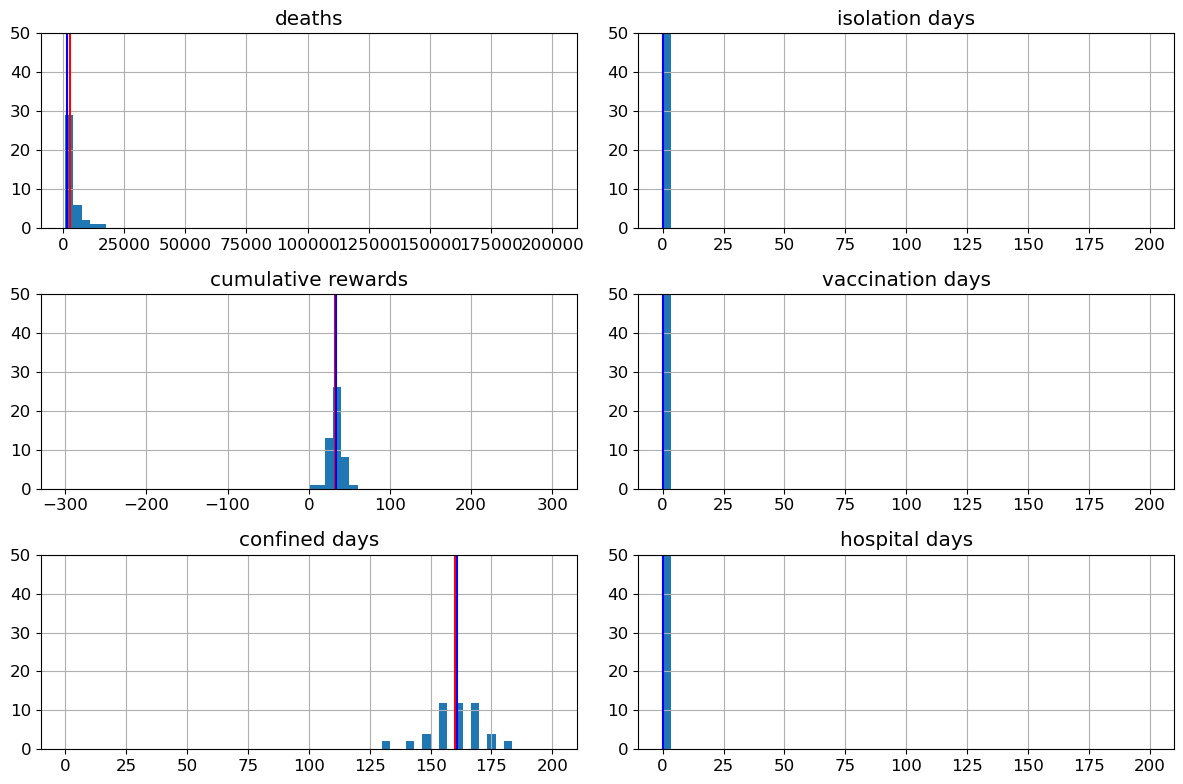

mean reward:  32.77968369461596
median reward:  32.92319977283478
mean death:  2899.4
median death:  1732.0
mean confinement:  159.88
median confinement:  161.0
mean isolation:  0.0
median isolation:  0.0
mean hospitalization:  0.0
median hospitalization:  0.0
mean vaccination:  0.0
median vaccination:  0.0


In [1330]:
### \pi_\text{FE-DQN}###

'''Rerun the action/observation preprocessor in Q3'''
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 2

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0, # greedy policy during evaluation
                  lr = 5e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

agent.load_model(f'dqn_process_2.pth')
agent.epsilon = 0

confine_list, dead_list, reward_list, isolate_list, hospital_list, vaccinate_list = evaluation_total(env, agent, times = 50)

fig, ax = plt.subplots(3,2,figsize=(12,8))
hist_avg(ax[0,0], dead_list,'deaths')
hist_avg(ax[1,0], reward_list,'cumulative rewards')
hist_avg(ax[2,0], confine_list,'confined days')
hist_avg(ax[0,1], isolate_list,'isolation days')
hist_avg(ax[1,1], vaccinate_list,'vaccination days')
hist_avg(ax[2,1], hospital_list,'hospital days')

fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))
print("mean isolation: ", np.mean(isolate_list))
print("median isolation: ", np.median(isolate_list))
print("mean hospitalization: ", np.mean(hospital_list))
print("median hospitalization: ", np.median(hospital_list))
print("mean vaccination: ", np.mean(vaccinate_list))
print("median vaccination: ", np.median(vaccinate_list))

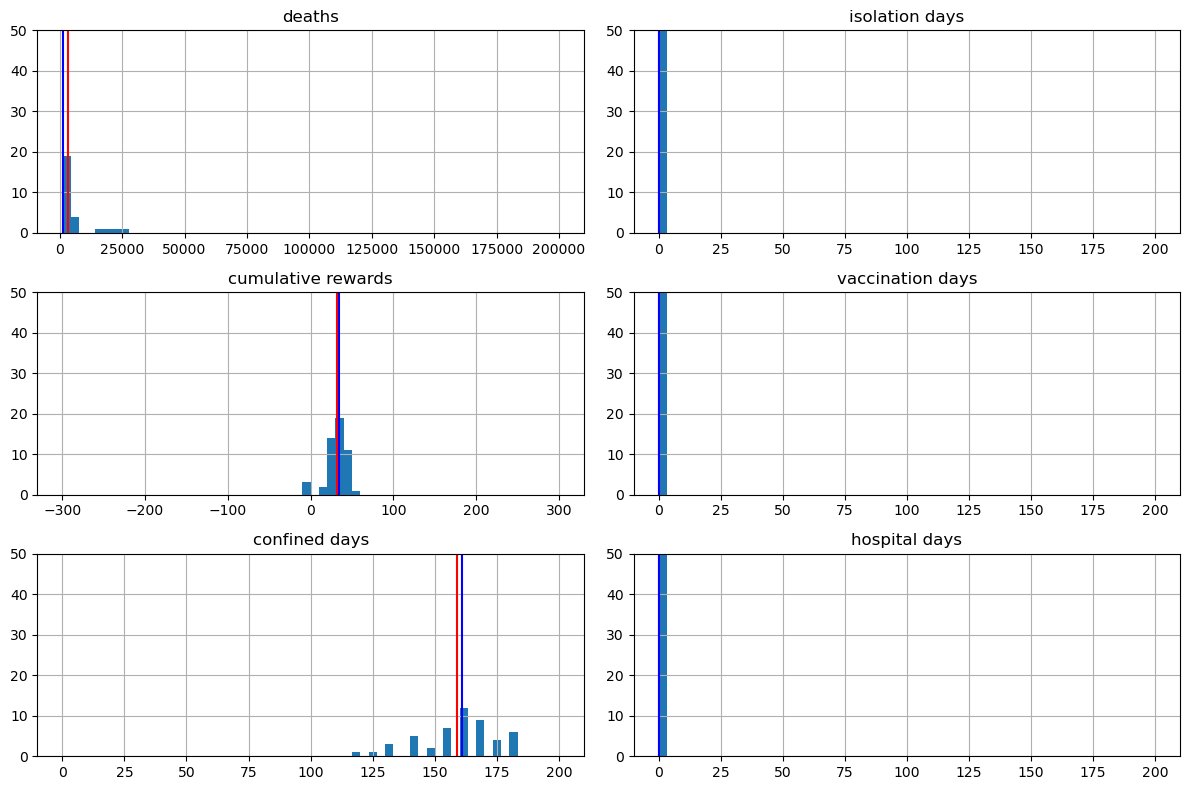

mean reward:  32.079850760549306
median reward:  33.94884730875492
mean death:  3129.98
median death:  1139.5
mean confinement:  159.04
median confinement:  161.0
mean isolation:  0.0
median isolation:  0.0
mean hospitalization:  0.0
median hospitalization:  0.0
mean vaccination:  0.0
median vaccination:  0.0


In [1271]:
### \pi_\text{DE-DQN}###

'''Rerun the action/observation preprocessor in Q3'''
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 2

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0, # greedy policy during evaluation
                  lr = 5e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

agent.load_model(f'DECREASING_dqn_process_2.pth')

confine_list, dead_list, reward_list, isolate_list, hospital_list, vaccinate_list = evaluation_total(env, agent, times = 50)

fig, ax = plt.subplots(3,2,figsize=(12,8))
hist_avg(ax[0,0], dead_list,'deaths')
hist_avg(ax[1,0], reward_list,'cumulative rewards')
hist_avg(ax[2,0], confine_list,'confined days')
hist_avg(ax[0,1], isolate_list,'isolation days')
hist_avg(ax[1,1], vaccinate_list,'vaccination days')
hist_avg(ax[2,1], hospital_list,'hospital days')

fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))
print("mean isolation: ", np.mean(isolate_list))
print("median isolation: ", np.median(isolate_list))
print("mean hospitalization: ", np.mean(hospital_list))
print("median hospitalization: ", np.median(hospital_list))
print("mean vaccination: ", np.mean(vaccinate_list))
print("median vaccination: ", np.median(vaccinate_list))

378


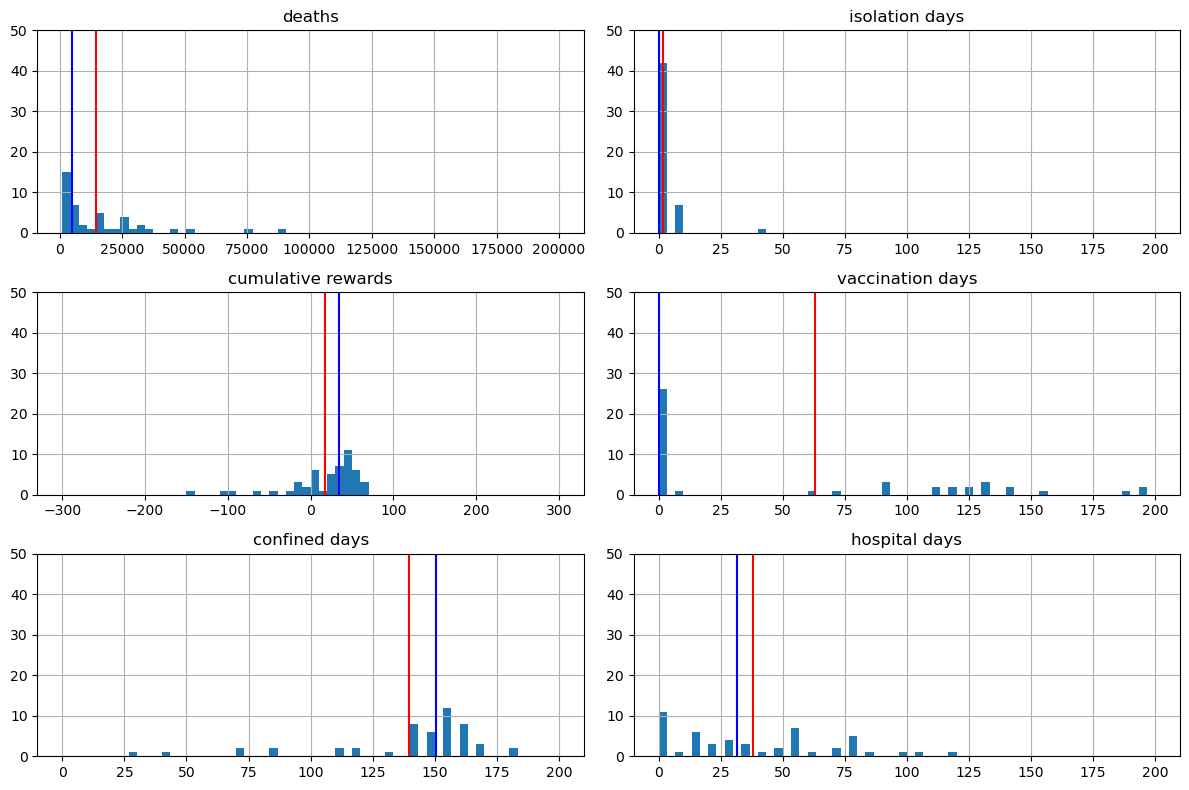

mean reward:  17.763152212102433
median reward:  34.86017306573922
mean death:  14643.0
median death:  4913.5
mean confinement:  139.58
median confinement:  150.5
mean isolation:  1.82
median isolation:  0.0
mean hospitalization:  37.94
median hospitalization:  31.5
mean vaccination:  63.0
median vaccination:  0.0


In [1253]:
### \pi_\text{toggle} ###
### lr = 1e-3; n_episodes = 500

'''Rerun the action/observation preprocessor in Q4.1'''
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 5 # 5 actions
print(input_size) # 378 = (2 + 4) * 9 * 7

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 1e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

agent.load_model(f'MA3_DECREASING_dqn_process_0.pth')
agent.epsilon = 0

confine_list, dead_list, reward_list, isolate_list, hospital_list, vaccinate_list = evaluation_total(env, agent, times = 50)

fig, ax = plt.subplots(3,2,figsize=(12,8))
hist_avg(ax[0,0], dead_list,'deaths')
hist_avg(ax[1,0], reward_list,'cumulative rewards')
hist_avg(ax[2,0], confine_list,'confined days')
hist_avg(ax[0,1], isolate_list,'isolation days')
hist_avg(ax[1,1], vaccinate_list,'vaccination days')
hist_avg(ax[2,1], hospital_list,'hospital days')

fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))
print("mean isolation: ", np.mean(isolate_list))
print("median isolation: ", np.median(isolate_list))
print("mean hospitalization: ", np.mean(hospital_list))
print("median hospitalization: ", np.median(hospital_list))
print("mean vaccination: ", np.mean(vaccinate_list))
print("median vaccination: ", np.median(vaccinate_list))



126


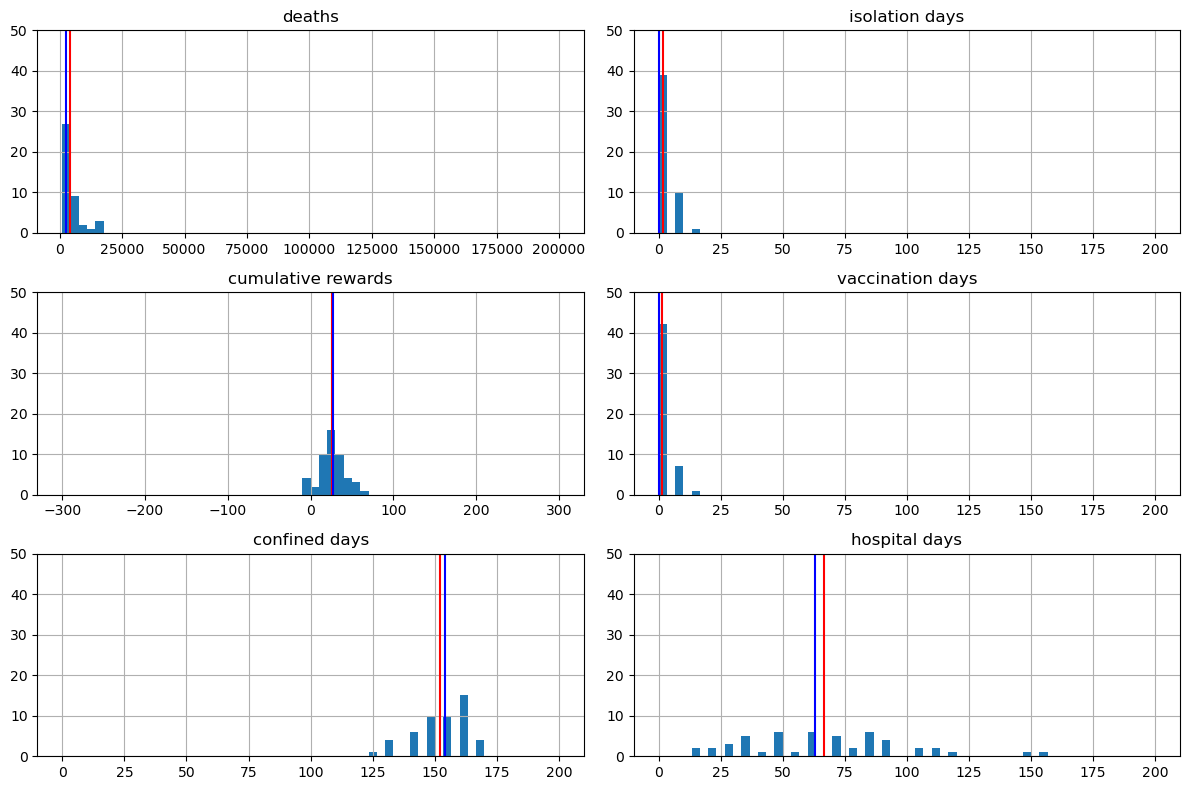

mean reward:  25.69870685205795
median reward:  26.566481885733083
mean death:  3899.7
median death:  2366.5
mean confinement:  151.9
median confinement:  154.0
mean isolation:  1.68
median isolation:  0.0
mean hospitalization:  66.5
median hospitalization:  63.0
mean vaccination:  1.26
median vaccination:  0.0


In [1258]:
### \pi_\text{factor} ###

'''Rerun the action/observation preprocessor in Q4.2'''
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset()
input_size = torch.flatten(obs).shape.numel()
output_size = 4 * 2 # 8 actions
print(input_size) # 126 = 2 * 9 * 7

agent = Factorized_DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 1e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

agent.load_model(f'MAFACT-3_DECREASING_dqn_process_0.pth')
agent.epsilon = 0

confine_list, dead_list, reward_list, isolate_list, hospital_list, vaccinate_list = evaluation_total(env, agent, times = 50)

fig, ax = plt.subplots(3,2,figsize=(12,8))
hist_avg(ax[0,0], dead_list,'deaths')
hist_avg(ax[1,0], reward_list,'cumulative rewards')
hist_avg(ax[2,0], confine_list,'confined days')
hist_avg(ax[0,1], isolate_list,'isolation days')
hist_avg(ax[1,1], vaccinate_list,'vaccination days')
hist_avg(ax[2,1], hospital_list,'hospital days')

fig.tight_layout()
plt.show()
print("mean reward: ", np.mean(reward_list))
print("median reward: ", np.median(reward_list))
print("mean death: ", np.mean(dead_list))
print("median death: ", np.median(dead_list))
print("mean confinement: ", np.mean(confine_list))
print("median confinement: ", np.median(confine_list))
print("mean isolation: ", np.mean(isolate_list))
print("median isolation: ", np.median(isolate_list))
print("mean hospitalization: ", np.mean(hospital_list))
print("median hospitalization: ", np.median(hospital_list))
print("mean vaccination: ", np.mean(vaccinate_list))
print("median vaccination: ", np.median(vaccinate_list))

In [1260]:
print(max(dead_list))

15672


Question 5c

In [1379]:
### heatmap: \pi_{factor}###
'''Rerun the action/observation preprocessor in Q4.2'''
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset(seed = 8)
input_size = torch.flatten(obs).shape.numel()
output_size = 4 * 2 # 8 actions
print(input_size) # 126 = 2 * 9 * 7

agent = Factorized_DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0.7, 
                  lr = 1e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

agent.load_model(f'MAFACT-3_DECREASING_dqn_process_0.pth')
agent.epsilon = 0


126


In [1380]:
finished = False
q_values_all = []
action_all = []
while not finished:
    q_values = agent.q_calculate(obs)[0].tolist()
    q_values_all.append(q_values)
    # print(q_values_all)
    action = agent.act(obs)
    # print(action)
    action_all.append(action)
    obs, _, finished, _ = env.step(action)

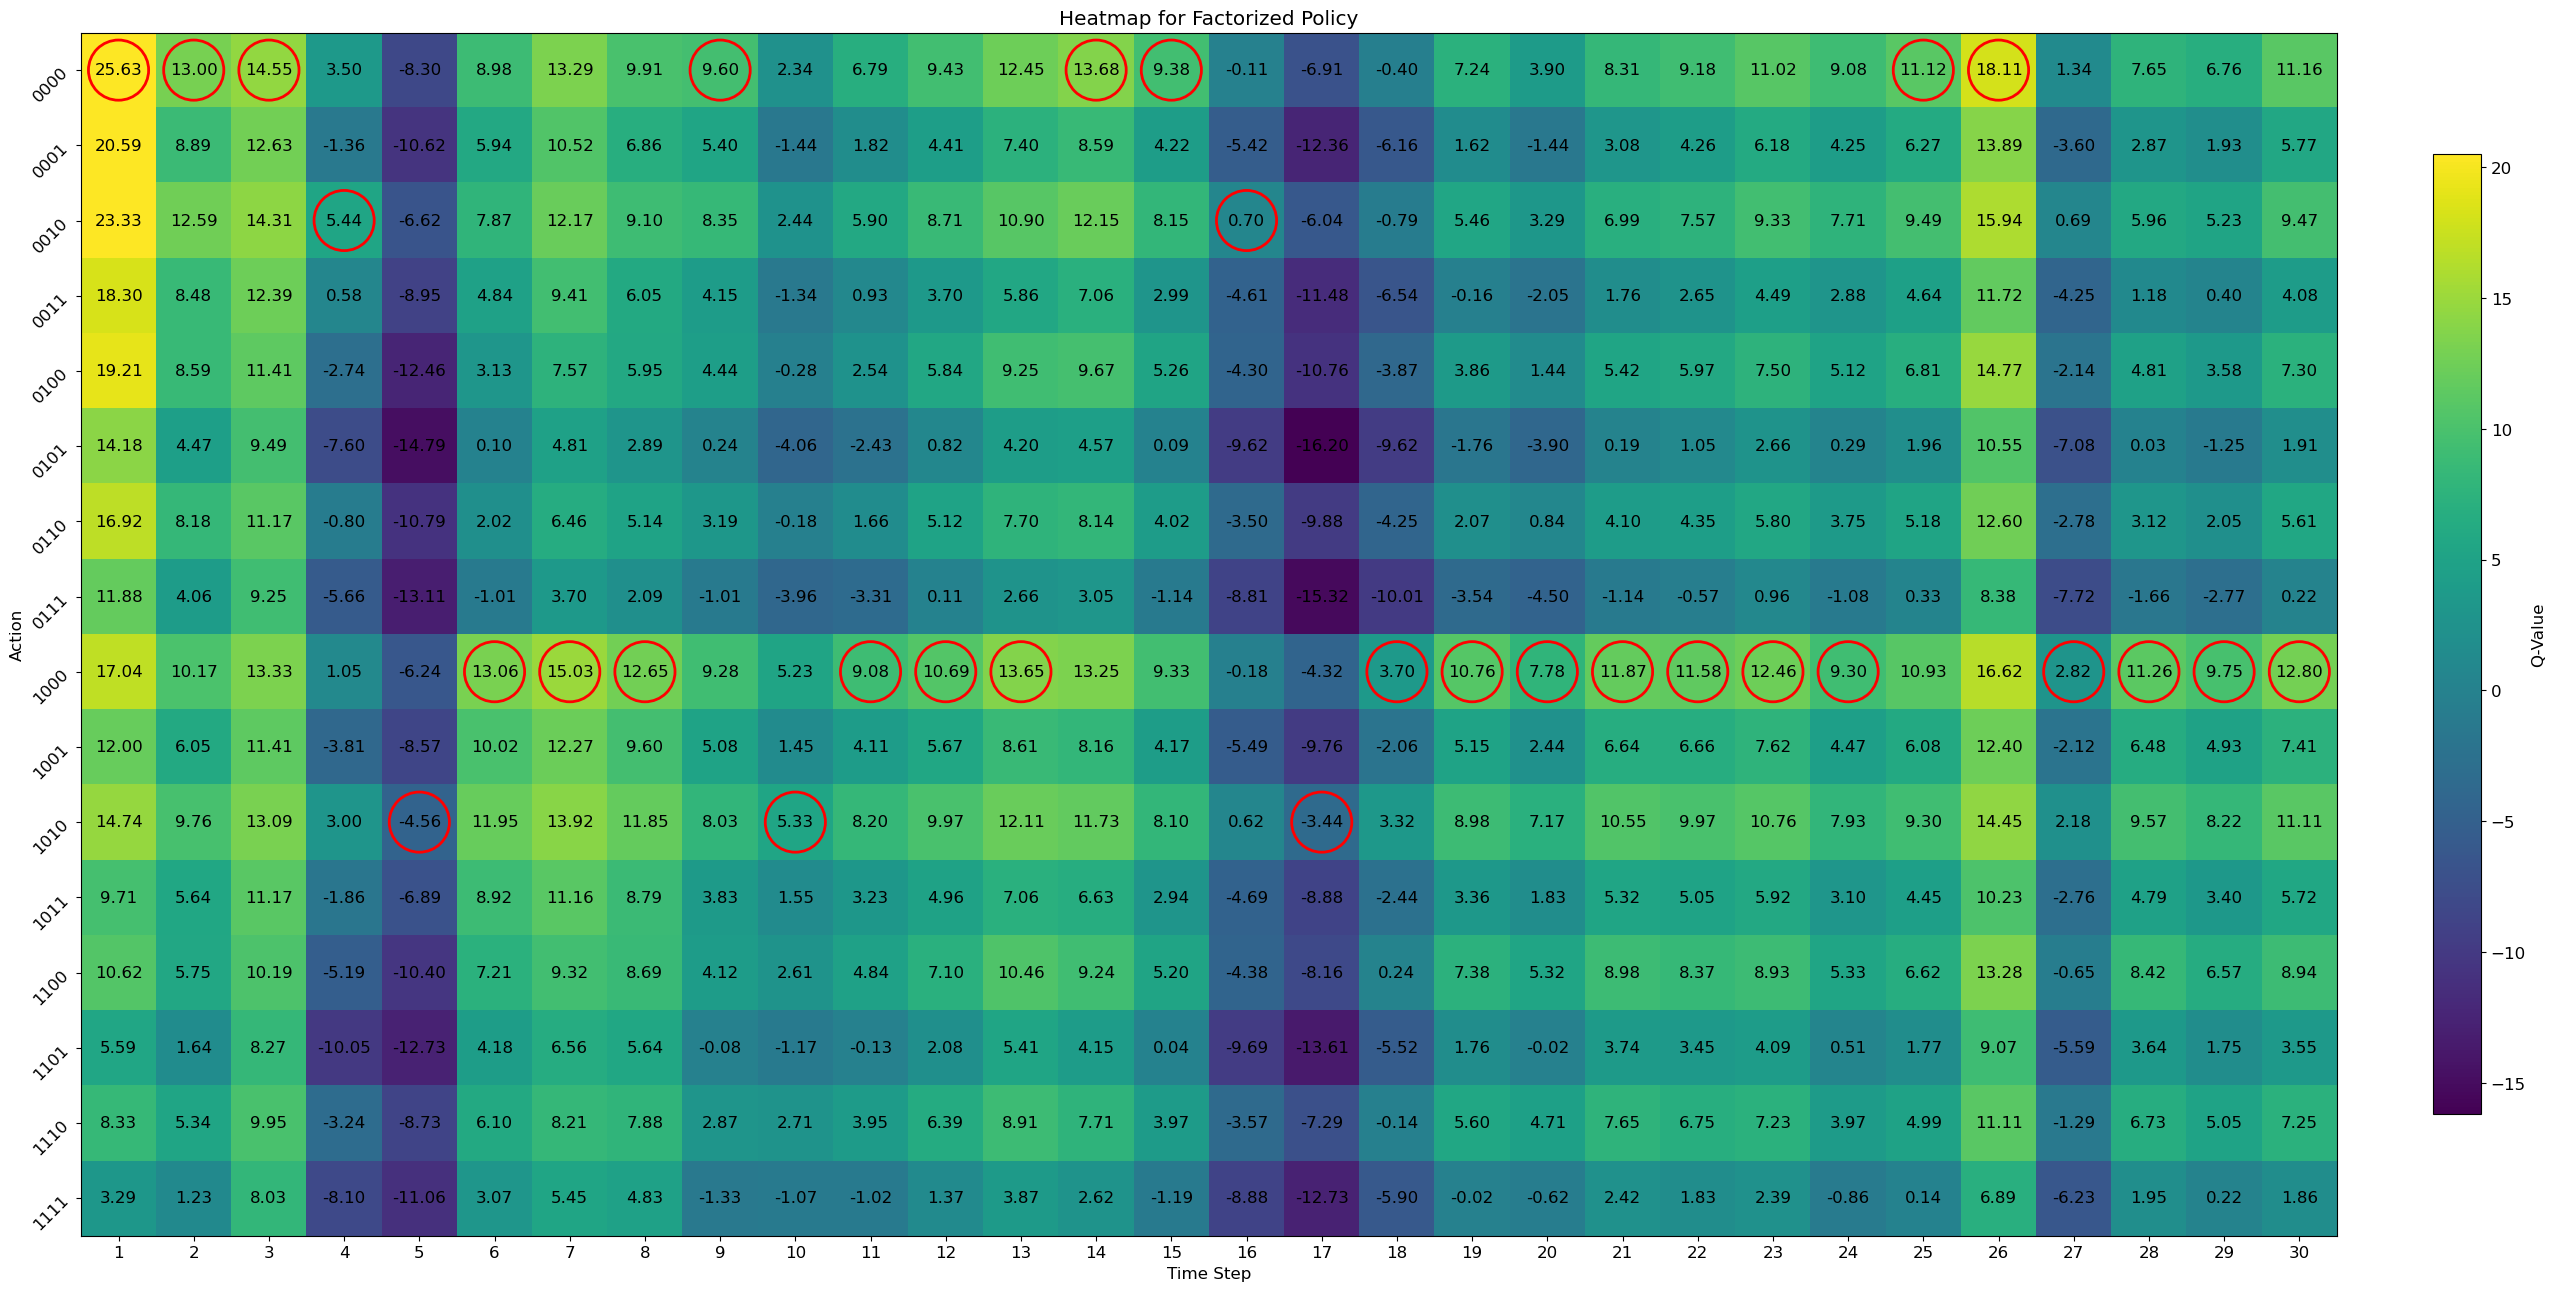

In [1381]:

# Generate random heatmap data
heatmap_data = np.array(q_values_all).T

# Adjust figure size and spacing
fig, ax = plt.subplots(figsize=(40, 25))
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.15)

# Plot the heatmap with a darker color scheme
heatmap = ax.imshow(heatmap_data, cmap='viridis', vmin=np.min(heatmap_data), vmax=np.max(heatmap_data)*0.8)

# Add text annotations for each position
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        ax.text(j, i, f'{heatmap_data[i, j]:.2f}', color='black',
                ha='center', va='center')

# Add circles for the optimal q-value
for t in range(heatmap_data.shape[1]):
    target_position = [int(action_all[t]), t]
    circle = plt.Circle(target_position[::-1], 0.4, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)

# Customize the colorbar
cbar = plt.colorbar(heatmap, ax=ax, fraction=0.02, pad=0.04)
cbar.set_label('Q-Value')  # Colorbar label

action_quadruple = []
for l in range(np.power(2, int(output_size/2))):
    action_quadruple.append(bin(l)[2:].zfill(4))

# Customize the plot
plt.title('Heatmap for Factorized Policy')  # Add a title
plt.xlabel('Time Step')  # X-axis label
plt.ylabel('Action')  # Y-axis label
plt.xticks(range(heatmap_data.shape[1]), range(1, heatmap_data.shape[1]+1))
plt.yticks(range(np.power(2, int(output_size/2))), action_quadruple, rotation=45)  # Custom y-axis labels

# Adjust text size
plt.rc('font', size=12)

# Display the plot
plt.show()


In [1373]:
### heatmap: \pi_{DQN} ###
'''Rerun the action/observation preprocessor in Q3'''
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )

obs, _ = env.reset(8)
input_size = torch.flatten(obs).shape.numel()
output_size = 2

agent = DQN_Agent(env, 
                  input_size,
                  output_size,
                  gamma = 0.9, 
                  epsilon = 0, # greedy policy during evaluation
                  lr = 5e-3, 
                  batch_size = 2048,
                  buffer_capacity = 20000
                  )

agent.load_model(f'dqn_process_2.pth')
agent.epsilon = 0

In [1374]:
finished = False
q_values_all = []
action_all = []
while not finished:
    q_values = agent.network(obs)[0].tolist()
    q_values_all.append(q_values)
    # print(q_values_all)
    action = agent.act(obs)
    # print(action)
    action_all.append(action)
    obs, _, finished, _ = env.step(action)

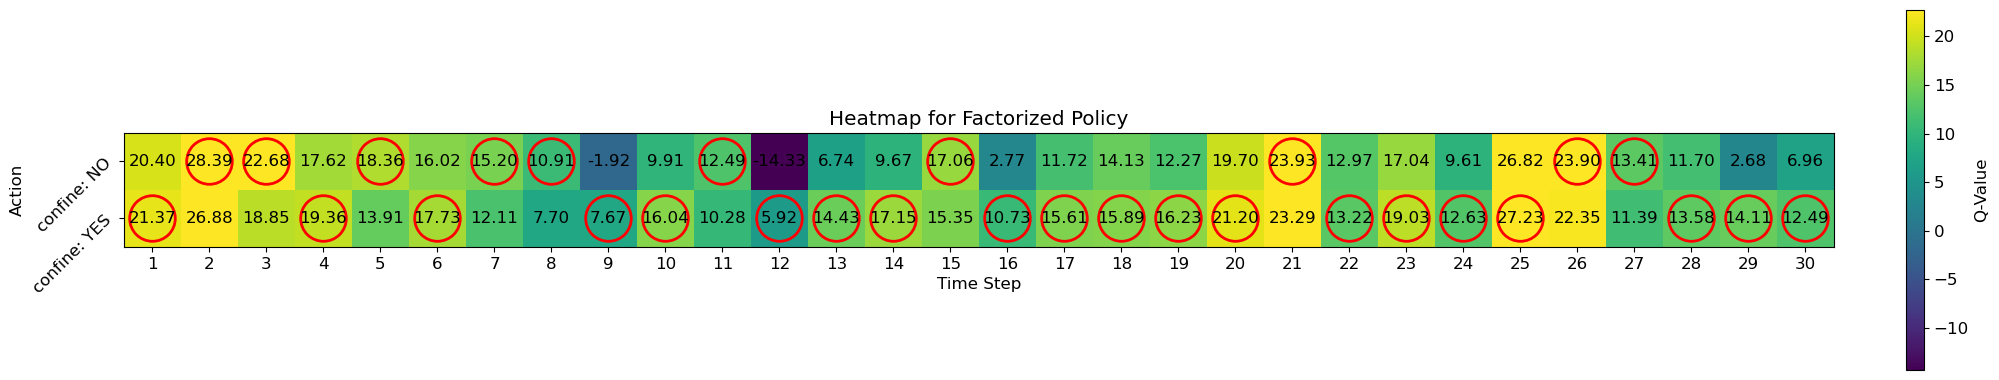

In [1377]:

# Generate random heatmap data
heatmap_data = np.array(q_values_all).T

# Adjust figure size and spacing
fig, ax = plt.subplots(figsize=(30, 8))
plt.subplots_adjust(left=0.2, right=0.8, top=0.9, bottom=0.15)

# Plot the heatmap with a darker color scheme
heatmap = ax.imshow(heatmap_data, cmap='viridis', vmin=np.min(heatmap_data), vmax=np.max(heatmap_data)*0.8)

# Add text annotations for each position
for i in range(heatmap_data.shape[0]):
    for j in range(heatmap_data.shape[1]):
        ax.text(j, i, f'{heatmap_data[i, j]:.2f}', color='black',
                ha='center', va='center')

# Add circles for toggled actions
for t in range(heatmap_data.shape[1]):
    a = action_all[t]
    target_position = [int(a), t]
    circle = plt.Circle(target_position[::-1], 0.4, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)

# Customize the colorbar
cbar = plt.colorbar(heatmap, ax=ax, fraction=0.01, pad=0.04)
cbar.set_label('Q-Value')  # Colorbar label

# Customize the plot
plt.title('Heatmap for Factorized Policy')  # Add a title
plt.xlabel('Time Step')  # X-axis label
plt.ylabel('Action')  # Y-axis label
plt.xticks(range(heatmap_data.shape[1]), range(1, heatmap_data.shape[1]+1))
plt.yticks(range(2), ['confine: NO', 'confine: YES'], rotation=45)  # Custom y-axis labels

# Adjust text size
plt.rc('font', size=12)

# Display the plot
plt.show()
